# Ngram tracing 
## as introduced by Grieve et al. 2017
 make sure that all excel tables are in the same folder as this jupyter notebook if you intend to execute cells.

In [1]:
# imports packages
import statistics as st
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
#import frog
from sklearn import svm
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, LeaveOneOut, ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
STOPWORDS = '.'
df = pd.read_excel('df_with_lemmata.xlsx')
df.set_index("ID", inplace = True)

In [2]:
df.head()

,Label,Taaloefening 1,Taaloefening 2,Text,Lemmas
ID,,,,,
P642,2,NaN,Terwijl de kok zijn deeg aan het voorbereiden ...,Terwijl de kok zijn deeg aan het voorbereiden ...,terwijl de kok zijn deeg aan_het voorbereiden ...
C021,0,"Je neemt de nodige hoeveelheid water, deze gie...",NaN,"Je neemt de nodige hoeveelheid water, deze gie...","je nemen de nodig hoeveelheid water , deze gie..."
C022,0,NaN,De kok is een pizza aan het maken in zijn rest...,De kok is een pizza aan het maken in zijn rest...,de kok zijn een pizza aan_het maken in zijn re...
C041,0,NaN,Op de printjes zie je een pizza maker die een ...,Op de printjes zie je een pizza maker die een ...,op de prin zien je een pizza maker die een dee...
C042,0,"Je neemt een hoog bokaal, een filter. De filte...",NaN,"Je neemt een hoog bokaal, een filter. De filte...","je nemen een hoog bokaal , een filter . de fil..."


In [3]:
textlength_c2 = []
textlength_c1 = []
c0_1 = []
c0_2 = []


pa_1 = []
pa_2 = []
textlength_pa1 = []
textlength_pa2 = []
pr_1 = []
pr_2 = []
textlength_pr1 = []
textlength_pr2 = []


for index, row in df.iterrows():
    if df.loc[index, "Label"] == 0:
        if isinstance(df.loc[index, "Taaloefening 1"], float) is not True:
            c0_1.append(df.loc[index, "Taaloefening 1"])
            textlength_c1.append(len(df.loc[index, "Taaloefening 1"]))
        if isinstance(df.loc[index, "Taaloefening 2"], float) is not True:
            c0_2.append(df.loc[index, "Taaloefening 2"])
            textlength_c2.append(len(df.loc[index, "Taaloefening 2"]))
            
    if df.loc[index, "Label"] == 1:
        if isinstance(df.loc[index, "Taaloefening 1"], float) is not True:
            pa_1.append(df.loc[index, "Taaloefening 1"])
            textlength_pa1.append(len(df.loc[index, "Taaloefening 1"]))

        if isinstance(df.loc[index, "Taaloefening 2"], float) is not True:
            pa_2.append(df.loc[index, "Taaloefening 2"])
            textlength_pa2.append(len(df.loc[index, "Taaloefening 2"]))

    if df.loc[index, "Label"] == 2:
        if isinstance(df.loc[index, "Taaloefening 1"], float) is not True:
            pr_1.append(df.loc[index, "Taaloefening 1"])
            textlength_pr1.append(len(df.loc[index, "Taaloefening 1"]))

        if isinstance(df.loc[index, "Taaloefening 2"], float) is not True:
            pr_2.append(df.loc[index, "Taaloefening 2"])
            textlength_pr2.append(len(df.loc[index, "Taaloefening 2"]))



In [4]:
df = pd.read_excel('schizophrenia_data_cleaned.xlsx')
# P662 exists twice, for Taaloefening 1 and 2 once
df.loc[df.index == 76, "Taaloefening 2"] = df.loc[166]["Taaloefening 2"]
# dropping irrelevant columns, LDP = "Livia de Picker", PANS = "Positive and Negative Syndromes. Can be ignored due to absence of exact test scores"
columns = ['LDP', 'Datum', 'PANS', 'Unnamed: 5', 'Unnamed: 11', 'Unnamed: 13','1_woord_streep', '1_zin_streep', '1_alinea_streep', '1_Typografisch', '1_Comment', "2_woord_streep", "2_zin_streep","2_alinea_streep", "2_Typografisch", "2_Comment","afterthought_word","Spelcorrecties","ALLCAPS","UPPERCASE","lowercase","afterthought_phrase"]
df.drop(columns, inplace=True, axis=1)
# add "labels" to dataframe; 0: control, 1: acute, 2: remission, 3: non-valid participant
labels = []
for index,row in df.iterrows():
    if row[0].startswith('C'):
        labels.append(0)
    elif row[0].startswith('P') and row[0].endswith("1"):
        labels.append(1)
    elif row[0].startswith('P') and row[0].endswith("2"):
        labels.append(2)
    else:
        df.drop(index, inplace=True, axis=0)
df.insert(0, "Label", labels, True)
df.set_index("ID", inplace = True)
# removes other duplicates of the data (e.g. P642)
df = df.loc[~df.index.duplicated(keep='first')]
# fixes a cell missing a 'nan' (- or data, but it's empty)
df.loc["C092", "Taaloefening 2"] = float('nan')
text = []
for index, row in df.iterrows():
    if isinstance(df.loc[index, "Taaloefening 1"], float) is not True:
        text.append(df.loc[index, "Taaloefening 1"])
    elif isinstance(df.loc[index, "Taaloefening 2"], float) is not True:
        text.append(df.loc[index, "Taaloefening 2"])
df["Text"] = text
frog = frog.Frog(frog.FrogOptions(parser=False))
def lemmatize(text):
    return ' '.join([word['lemma'] for word in frog.process(text) if word])
lemmas = []  
for index, row in df.iterrows():
    lemmas.append(lemmatize(df.loc[index, "Text"]))
    
df["Lemmas"] = lemmas

NameError: name 'frog' is not defined

## N-Gram-Tracing
Defines all necessary functions for N-Gram-Tracing

In [5]:
# generate ngrams WITHOUT crossing sentence boundaries
def generate_ngram(source, chars_or_words, ngram_order):
    """
    Input: Source: string of words, chars_or_words: ngrams with "characters" or "words", ngram_order: integer (unigram, bigram, trigram,...)
    Output: List with tuples of ngrams (strings)
    """
    list_of_tuples = []
    output = []
    source = source.lower()
    
    if chars_or_words == "words":
        for word in source.split():
            if '.' in word:
                output.append(word[:-1])
                output.append(".")
            elif '.' not in word:
                output.append(word)
        source = output
            
    for i in range(0, len(source) - ngram_order + 1):
        
        ngram_order_index = i + ngram_order
        generated_ngram = tuple(source[i : ngram_order_index])
        if chars_or_words == "chars":
            if not any(w in STOPWORDS for w in generated_ngram[:-1]):
                list_of_tuples.append(generated_ngram)
                
        if chars_or_words == "words":
            if not any(ngrams in STOPWORDS for ngrams in generated_ngram[:-1]):
                list_of_tuples.append(generated_ngram)
                
    return list_of_tuples

def overlapp_coefficient(set_of_ngrams1,set_of_ngrams2):
    """
    Input: Two sets of ngrams that are tested against each other
    Output: Overlapp Co-Efficient as described by Grieve et al. 2017:
    > Measures the percentage of n-gram types found in the questioned document that also occur at least once in each possible author 
    (=> participant group) writing sample. <
    """
    
    return len(set(set_of_ngrams1).intersection(set(set_of_ngrams2))) / len(set(set_of_ngrams1))

def create_dataframe(task, chars_or_words, ngram_order, amount_of_groups, participant_grouping):
    """
    Creates a dataframe with all ngrams and random ngram selection based on whether the input was "word" or "chars", the ngram order
    the amount of groups "two_groups" or "three_groups" and the constellation of participant_grouping: None, "controls_vs_patients" or "controlsremission_vs_acute" 
    """ 
    if task == 1:
        return ngram_tracing_main("Taaloefening 1", chars_or_words, ngram_order, amount_of_groups, participant_grouping)
    if task == 2:
        return ngram_tracing_main("Taaloefening 2", chars_or_words, ngram_order, amount_of_groups, participant_grouping)

    if task == "both":
        df_ngrams_1 = ngram_tracing_main("Taaloefening 1", chars_or_words, ngram_order, amount_of_groups, participant_grouping)
        df_ngrams_2 = ngram_tracing_main("Taaloefening 2", chars_or_words, ngram_order, amount_of_groups, participant_grouping)
        return pd.concat([df_ngrams_1, df_ngrams_2], ignore_index=True)
    
def ngram_tracing_main(task, chars_or_words, ngram_order, amount_of_groups, participant_grouping):
    """
    Input: takes the file to be tested (test_file), the task (Taaloefening 1 or 2), 
        whether ngrams should be made of characters or words (chars_or_words) and the ngram order
    Output: creates a bag of ngrams for the testfile and each participant group, calculates the overlap coefficient for all 3 test cases, 
        chooses the highest and adds the results to a list of lists "data" which will be appended to the ngram dataframe later.
    """
    data = []
    for participant in df.index:
        
        ngrams0 = []
        ngrams1 = []
        ngrams2 = []
        lemmasngrams0 = []
        lemmasngrams1 = []
        lemmasngrams2 = []
        merged_label = 0
        
        if isinstance(df.loc[participant, task], float) is not True:
            participant_ngrams = generate_ngram(df.loc[participant, task], chars_or_words, ngram_order)
            if participant_grouping == "controls_vs_patients":
                if df.loc[participant, "Label"] == 2:
                    merged_label = 1
                else:
                    merged_label = df.loc[participant, "Label"]
            elif participant_grouping == "controlsremission_vs_acute":
                if df.loc[participant, "Label"] == 2:
                    merged_label = 0
                else:
                    merged_label = df.loc[participant, "Label"]
        
            for participant2 in df.index:
                if participant2 != participant:
                
                    if amount_of_groups == "three_groups":
                        if df.loc[participant2, "Label"] == 0:
                            if isinstance(df.loc[participant2, task], float) is not True:
                                ngrams0 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                lemmasngrams0 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                        elif df.loc[participant2, "Label"] == 1:
                            if isinstance(df.loc[participant2, task], float) is not True:
                                ngrams1 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                lemmasngrams1 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                        elif df.loc[participant2, "Label"] == 2:
                            if isinstance(df.loc[participant2, task], float) is not True:
                                ngrams2 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                lemmasngrams2 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                    elif amount_of_groups == "two_groups":
                        if participant_grouping == "controls_vs_patients":
                            if df.loc[participant2, "Label"] == 0:
                                if isinstance(df.loc[participant2, task], float) is not True:
                                    ngrams0 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                    lemmasngrams0 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                            elif df.loc[participant2, "Label"] == 1:
                                if isinstance(df.loc[participant2, task], float) is not True:
                                    ngrams1 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                    lemmasngrams1 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                            elif df.loc[participant2, "Label"] == 2:
                                if isinstance(df.loc[participant2, task], float) is not True:
                                    ngrams1 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                    lemmasngrams1 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                        elif participant_grouping == "controlsremission_vs_acute":
                            if df.loc[participant2, "Label"] == 0:
                                if isinstance(df.loc[participant2, task], float) is not True:
                                    ngrams0 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                    lemmasngrams0 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

                                    
                            elif df.loc[participant2, "Label"] == 2:
                                if isinstance(df.loc[participant2, task], float) is not True:
                                    ngrams0 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                    lemmasngrams0 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)


                            elif df.loc[participant2, "Label"] == 1:
                                if isinstance(df.loc[participant2, task], float) is not True:
                                    ngrams1 += generate_ngram(df.loc[participant2, task], chars_or_words, ngram_order)
                                    lemmasngrams1 += generate_ngram(df.loc[participant2, "Lemmas"], chars_or_words, ngram_order)

            
            if amount_of_groups == "three_groups":
                smallest_sample = min(len(ngrams0), len(ngrams1), len(ngrams2))
                smallest_lemmasample = min(len(lemmasngrams0), len(lemmasngrams1), len(lemmasngrams2))
            elif amount_of_groups == "two_groups":
                smallest_sample = min(len(ngrams0), len(ngrams1))
                smallest_lemmasample = min(len(lemmasngrams0), len(lemmasngrams1))
                
            random0 = random.sample(ngrams0, smallest_sample)
            random1 = random.sample(ngrams1, smallest_sample)
            randomlemma0 = random.sample(lemmasngrams0, smallest_lemmasample)
            randomlemma1 = random.sample(lemmasngrams1, smallest_lemmasample)

            ngrams0_ratio = overlapp_coefficient(participant_ngrams,random0)
            ngrams1_ratio = overlapp_coefficient(participant_ngrams,random1)
            lemmas0_ratio = overlapp_coefficient(participant_ngrams,randomlemma0)
            lemmas1_ratio = overlapp_coefficient(participant_ngrams,randomlemma1)
        
            if amount_of_groups == "two_groups":
                ratio_list = [ngrams0_ratio, ngrams1_ratio]
                lemmaratio_list = [lemmas0_ratio, lemmas1_ratio]
                overlap_difference = abs(ngrams0_ratio - ngrams1_ratio)
                lemma_overlap_difference = abs(lemmas0_ratio - lemmas1_ratio)

            elif amount_of_groups == "three_groups":
                random2 = random.sample(ngrams2, smallest_sample)
                randomlemma2 = random.sample(lemmasngrams2, smallest_lemmasample)
                ngrams2_ratio = overlapp_coefficient(participant_ngrams,random2)
                lemmas2_ratio = overlapp_coefficient(participant_ngrams,randomlemma2)
                ratio_list = [ngrams0_ratio, ngrams1_ratio, ngrams2_ratio]
                lemmaratio_list = [lemmas0_ratio, lemmas1_ratio, lemmas2_ratio]
                difference_list = ratio_list.copy()
                difference_list_lemmas = lemmaratio_list.copy()
                minimum = min(difference_list)
                minimumlemmas = min(difference_list_lemmas)
                difference_list.remove(minimum)
                difference_list_lemmas.remove(minimumlemmas)
                overlap_difference = abs(difference_list[0] - difference_list[1])
                overlap_difference_lemmas = abs(difference_list_lemmas[0] - difference_list_lemmas[1])
            
            if max(ratio_list) == 0.0:
                predicted_label = float('nan')
                predicted_label_lemmas = lemmaratio_list.index(max(lemmaratio_list))
            else:
                predicted_label = ratio_list.index(max(ratio_list))
                predicted_label_lemmas = lemmaratio_list.index(max(lemmaratio_list))
        
            if amount_of_groups == "three_groups":
                data.append([participant, df.loc[participant, "Label"], predicted_label,predicted_label_lemmas,  overlap_difference, ngrams0_ratio, ngrams1_ratio, ngrams2_ratio, participant_ngrams, random0, random1, random2, ngrams0, ngrams1, ngrams2])
                df_ngrams = pd.DataFrame(data, columns = ['Participant', 'Label', 'Predicted Label', "Predicted Label Lemmas", "Overlap Difference",  'Overlap with Label 0', 'Overlap with Label 1', "Overlap with Label 2", "Participant Ngrams", "Random 0", "Random 1", "Random 2", "Ngrams 0", "Ngrams 1", "Ngrams 2"])

            elif amount_of_groups == "two_groups":
                data.append([participant, merged_label, predicted_label, predicted_label_lemmas, overlap_difference, ngrams0_ratio, ngrams1_ratio, participant_ngrams, random0, random1, ngrams0, ngrams1]) 
                df_ngrams = pd.DataFrame(data, columns = ['Participant', 'Label', 'Predicted Label', "Predicted Label Lemmas", "Overlap Difference",  'Overlap with Label 0', 'Overlap with Label 1', "Participant Ngrams", "Random 0", "Random 1", "Ngrams 0", "Ngrams 1"])
    return df_ngrams

def accuracy(dataframe):
    """
    Prints the Accuracy, the amount of correctly predicted participants and the amount of all participants
    """
    correctly_predicted = 0
    for index,row in dataframe.iterrows():
        if row[1] == row[2]:
            correctly_predicted += 1
    accuracy = correctly_predicted / len(dataframe)
    ac_counter.append(accuracy)
    correctly_predicted_lemmas = 0
    for index,row in dataframe.iterrows():
        if row[1] == row[3]:
            correctly_predicted_lemmas += 1
    accuracy_lemmas = correctly_predicted_lemmas / len(dataframe)
    le_counter.append(accuracy_lemmas)
    #print("Correctly predicted:", correctly_predicted, "/", len(dataframe))
    #print("Accuracy:", accuracy, "Accuracy with Lemmas", accuracy_lemmas, "\n",)
    return(ac_counter, le_counter)

def supportvectormachine(X, y, X_train, y_train):
    SVM = SVC(kernel='linear')
    SVM.fit(X_train, y_train)
    y_pred = SVM.predict(X_test)
    scores = cross_val_score(SVM, X, y, cv=5)
    print("---------- Support Vector Machine ----------","\n")
    return SVM, y_pred, scores

def naivebayes(X, y, X_train, y_train):
    NB = MultinomialNB()
    NB.fit(X_train, y_train)
    y_pred = NB.predict(X_test)
    scores = cross_val_score(NB, X, y, cv=5)
    print("---------- Naive Bayes ----------")
    return NB, y_pred, scores

def classifierresults(X, y, y_test, y_pred, scores, model):
    print("Confusion Matrix:","\n",confusion_matrix(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    seed = 7
    test_size = 0.33
    kfold = KFold(n_splits=25, random_state=seed)
    results = cross_val_score(model, X, y, cv=kfold)
    print("K-Fold Cross Validation: Accuracy: %.3f%% (+/- %.3f%%)" % (results.mean()*100.0, results.std()*100.0))
    loocv = LeaveOneOut()
    results = cross_val_score(model, X, y, cv=loocv)
    print("Leave-One-Out Cross Validation: Accuracy: %.3f%% (+/- %.3f%%)" % (results.mean()*100.0, results.std()*100.0))
    kfold = ShuffleSplit(n_splits=10, test_size=test_size, random_state=seed)
    results = cross_val_score(model, X, y, cv=kfold)
    print("Repeated Random Test-Train Splits: Accuracy: %.3f%% (+/- %.3f%%)" % (results.mean()*100.0, results.std()*100.0))

## The following cells create a dataframe with the ngram tracing data with one row per participant. It calculates the accuracy, confusion matrix and prints some cases of "clear decision"
add a new cell with "df_ngrams" or "df_ngrams.head()" to have a closer look at the dataframes

In [403]:
# Taaloefening 1 with word ngrams, ngram order 1 and the three groups control vs acute vs remission
# parameters for "two_groups": controls_vs_patients controlsremission_vs_acute

ac_counter = []
le_counter = []
for _ in range(10):
    df_ngrams = create_dataframe(both,"chars", 2, "three_groups", participant_grouping = None)
    y_test = df_ngrams["Label"]; y_pred = df_ngrams["Predicted Label"]
    accuracy(df_ngrams)
    
    # have the classification report and confusion matrix additionally printed to each iteration
    #print(classification_report(y_test, y_pred))
    #print(confusion_matrix(y_test, y_pred))
    
print("Average Accuracy over all iterations for raw words <ac>":, sum(ac_counter) / len(ac_counter))
print(ac_counter)
print("Average Accuracy over all iterations for lemmata <le>"sum(le_counter) / len(le_counter))
print(le_counter)

0.4544303797468355
[0.379746835443038, 0.4936708860759494, 0.5063291139240507, 0.4810126582278481, 0.3670886075949367, 0.43037974683544306, 0.4430379746835443, 0.46835443037974683, 0.4936708860759494, 0.4810126582278481]
0.4341772151898734
[0.5063291139240507, 0.45569620253164556, 0.3670886075949367, 0.3670886075949367, 0.43037974683544306, 0.3924050632911392, 0.4936708860759494, 0.4177215189873418, 0.4177215189873418, 0.4936708860759494]


## The following 3 cells manually store the information from ALL ngram accuracies (DON'T DELETE)

In [1]:
le1words_1 = [0.40476190476190477, 0.30952380952380953, 0.36904761904761907, 0.2857142857142857, 0.3333333333333333, 0.3333333333333333, 0.36904761904761907, 0.32142857142857145, 0.32142857142857145, 0.35714285714285715]
le2words_1 = [0.21428571428571427, 0.2976190476190476, 0.21428571428571427, 0.27380952380952384, 0.25, 0.2619047619047619, 0.2976190476190476, 0.2857142857142857, 0.32142857142857145, 0.27380952380952384]
le3words_1 = [0.4642857142857143, 0.5119047619047619, 0.4642857142857143, 0.40476190476190477, 0.4880952380952381, 0.5595238095238095, 0.4166666666666667, 0.5238095238095238, 0.5357142857142857, 0.5357142857142857]
le3chars_1 = [0.35714285714285715, 0.4166666666666667, 0.36904761904761907, 0.32142857142857145, 0.39285714285714285, 0.4166666666666667, 0.38095238095238093, 0.47619047619047616, 0.47619047619047616, 0.4166666666666667]
le4chars_1 = [0.35714285714285715, 0.44047619047619047, 0.44047619047619047, 0.34523809523809523, 0.2857142857142857, 0.35714285714285715, 0.32142857142857145, 0.2976190476190476, 0.38095238095238093, 0.35714285714285715]
le5chars_1 = [0.2857142857142857, 0.30952380952380953, 0.32142857142857145, 0.42857142857142855, 0.2619047619047619, 0.4166666666666667, 0.35714285714285715, 0.30952380952380953, 0.36904761904761907, 0.3333333333333333]
le6chars_1 = [0.23809523809523808, 0.2619047619047619, 0.2976190476190476, 0.2261904761904762, 0.20238095238095238, 0.20238095238095238, 0.2857142857142857, 0.3333333333333333, 0.27380952380952384, 0.25]
le7chars_1 = [0.2619047619047619, 0.27380952380952384, 0.2619047619047619, 0.21428571428571427, 0.21428571428571427, 0.2619047619047619, 0.2261904761904762, 0.2619047619047619, 0.2261904761904762, 0.2619047619047619]
le8chars_1 = [0.21428571428571427, 0.23809523809523808, 0.21428571428571427, 0.2857142857142857, 0.2976190476190476, 0.17857142857142858, 0.17857142857142858, 0.2261904761904762, 0.21428571428571427, 0.2619047619047619]
le9chars_1 = [0.21428571428571427, 0.23809523809523808, 0.2619047619047619, 0.2857142857142857, 0.25, 0.2619047619047619, 0.23809523809523808, 0.20238095238095238, 0.27380952380952384, 0.2857142857142857]
le10chars_1 = [0.27380952380952384, 0.2619047619047619, 0.2261904761904762, 0.25, 0.25, 0.2619047619047619, 0.20238095238095238, 0.23809523809523808, 0.27380952380952384, 0.3333333333333333]
le11chars_1 = [0.39285714285714285, 0.2976190476190476, 0.30952380952380953, 0.23809523809523808, 0.2976190476190476, 0.3333333333333333, 0.2857142857142857, 0.30952380952380953, 0.35714285714285715, 0.27380952380952384]
le12chars_1 = [0.23809523809523808, 0.2261904761904762, 0.2976190476190476, 0.2857142857142857, 0.34523809523809523, 0.30952380952380953, 0.3333333333333333, 0.3333333333333333, 0.32142857142857145, 0.35714285714285715]
le13chars_1 = [0.32142857142857145, 0.30952380952380953, 0.30952380952380953, 0.2857142857142857, 0.32142857142857145, 0.27380952380952384, 0.25, 0.3333333333333333, 0.39285714285714285, 0.32142857142857145]
le14chars_1 = [0.23809523809523808, 0.3333333333333333, 0.32142857142857145, 0.30952380952380953, 0.32142857142857145, 0.32142857142857145, 0.23809523809523808, 0.39285714285714285, 0.32142857142857145, 0.3333333333333333]
le15chars_1 = [0.30952380952380953, 0.2976190476190476, 0.30952380952380953, 0.36904761904761907, 0.3333333333333333, 0.35714285714285715, 0.34523809523809523, 0.25, 0.36904761904761907, 0.34523809523809523]
le16chars_1 = [0.32142857142857145, 0.27380952380952384, 0.4166666666666667, 0.2857142857142857, 0.34523809523809523, 0.38095238095238093, 0.3333333333333333, 0.34523809523809523, 0.32142857142857145, 0.3333333333333333]
ac1words_1 = [0.34523809523809523, 0.32142857142857145, 0.3333333333333333, 0.2976190476190476, 0.40476190476190477, 0.35714285714285715, 0.34523809523809523, 0.4166666666666667, 0.35714285714285715, 0.35714285714285715]
ac2words_1 = [0.2976190476190476, 0.2976190476190476, 0.35714285714285715, 0.35714285714285715, 0.30952380952380953, 0.2619047619047619, 0.2619047619047619, 0.30952380952380953, 0.2976190476190476, 0.2976190476190476]
ac3words_1 = [0.38095238095238093, 0.34523809523809523, 0.3333333333333333, 0.40476190476190477, 0.27380952380952384, 0.40476190476190477, 0.4166666666666667, 0.42857142857142855, 0.3333333333333333, 0.38095238095238093]
ac3chars_1 = [0.4642857142857143, 0.47619047619047616, 0.40476190476190477, 0.44047619047619047, 0.4642857142857143, 0.4166666666666667, 0.42857142857142855, 0.34523809523809523, 0.42857142857142855, 0.42857142857142855]
ac4chars_1 = [0.3333333333333333, 0.38095238095238093, 0.40476190476190477, 0.34523809523809523, 0.32142857142857145, 0.47619047619047616, 0.4166666666666667, 0.34523809523809523, 0.38095238095238093, 0.40476190476190477]
ac5chars_1 = [0.27380952380952384, 0.2619047619047619, 0.2976190476190476, 0.30952380952380953, 0.2976190476190476, 0.39285714285714285, 0.34523809523809523, 0.27380952380952384, 0.32142857142857145, 0.30952380952380953]
ac6chars_1 = [0.2857142857142857, 0.2976190476190476, 0.30952380952380953, 0.32142857142857145, 0.2976190476190476, 0.25, 0.34523809523809523, 0.32142857142857145, 0.34523809523809523, 0.25]
ac7chars_1 = [0.2857142857142857, 0.2619047619047619, 0.2619047619047619, 0.2857142857142857, 0.30952380952380953, 0.25, 0.23809523809523808, 0.27380952380952384, 0.25, 0.23809523809523808]
ac8chars_1 = [0.2261904761904762, 0.2619047619047619, 0.2976190476190476, 0.2976190476190476, 0.20238095238095238, 0.2976190476190476, 0.2261904761904762, 0.2619047619047619, 0.2976190476190476, 0.2976190476190476]
ac9chars_1 = [0.30952380952380953, 0.27380952380952384, 0.2857142857142857, 0.2857142857142857, 0.32142857142857145, 0.2261904761904762, 0.2857142857142857, 0.30952380952380953, 0.34523809523809523, 0.27380952380952384]
ac10chars_1 = [0.32142857142857145, 0.27380952380952384, 0.2976190476190476, 0.38095238095238093, 0.3333333333333333, 0.34523809523809523, 0.30952380952380953, 0.34523809523809523, 0.2976190476190476, 0.32142857142857145]
ac11chars_1 = [0.32142857142857145, 0.30952380952380953, 0.3333333333333333, 0.34523809523809523, 0.32142857142857145, 0.36904761904761907, 0.30952380952380953, 0.32142857142857145, 0.34523809523809523, 0.30952380952380953]
ac12chars_1 = [0.34523809523809523, 0.38095238095238093, 0.44047619047619047, 0.34523809523809523, 0.38095238095238093, 0.34523809523809523, 0.39285714285714285, 0.35714285714285715, 0.39285714285714285, 0.34523809523809523]
ac13chars_1 = [0.4166666666666667, 0.3333333333333333, 0.2857142857142857, 0.35714285714285715, 0.35714285714285715, 0.4166666666666667, 0.42857142857142855, 0.35714285714285715, 0.35714285714285715, 0.38095238095238093]
ac14chars_1 = [0.38095238095238093, 0.35714285714285715, 0.27380952380952384, 0.36904761904761907, 0.23809523809523808, 0.42857142857142855, 0.34523809523809523, 0.39285714285714285, 0.30952380952380953, 0.35714285714285715]
ac15chars_1 = [0.30952380952380953, 0.2976190476190476, 0.32142857142857145, 0.34523809523809523, 0.34523809523809523, 0.39285714285714285, 0.40476190476190477, 0.4166666666666667, 0.42857142857142855, 0.34523809523809523]
ac16chars_1 = [0.40476190476190477, 0.2976190476190476, 0.36904761904761907, 0.32142857142857145, 0.2857142857142857, 0.32142857142857145, 0.25, 0.32142857142857145, 0.39285714285714285, 0.35714285714285715]
# two groups
con_acurem_le1words_1 = [0.44047619047619047, 0.5, 0.5714285714285714, 0.5476190476190477, 0.4642857142857143, 0.5, 0.5476190476190477, 0.5476190476190477, 0.5238095238095238, 0.5119047619047619]
con_acurem_le2words_1 = [0.5119047619047619, 0.6547619047619048, 0.5595238095238095, 0.5833333333333334, 0.4880952380952381, 0.5714285714285714, 0.6190476190476191, 0.5833333333333334, 0.5714285714285714, 0.5119047619047619]
con_acurem_le3words_1 = [0.5476190476190477, 0.5833333333333334, 0.4880952380952381, 0.5595238095238095, 0.5476190476190477, 0.5595238095238095, 0.5357142857142857, 0.5833333333333334, 0.5952380952380952, 0.5357142857142857]
con_acurem_le3chars_1 = [0.5595238095238095, 0.5595238095238095, 0.5238095238095238, 0.6071428571428571, 0.6547619047619048, 0.6309523809523809, 0.5238095238095238, 0.5833333333333334, 0.5595238095238095, 0.5714285714285714]
con_acurem_le4chars_1 = [0.6071428571428571, 0.5833333333333334, 0.6071428571428571, 0.5476190476190477, 0.5714285714285714, 0.5952380952380952, 0.5714285714285714, 0.5714285714285714, 0.5357142857142857, 0.5595238095238095]
con_acurem_le5chars_1 = [0.6071428571428571, 0.5595238095238095, 0.5833333333333334, 0.6428571428571429, 0.5833333333333334, 0.5952380952380952, 0.6190476190476191, 0.5595238095238095, 0.6190476190476191, 0.5833333333333334]
con_acurem_le6chars_1 = [0.5952380952380952, 0.5714285714285714, 0.6071428571428571, 0.6785714285714286, 0.6190476190476191, 0.6190476190476191, 0.6071428571428571, 0.5833333333333334, 0.6428571428571429, 0.6071428571428571]
con_acurem_le7chars_1 = [0.6190476190476191, 0.6190476190476191, 0.6666666666666666, 0.6309523809523809, 0.6190476190476191, 0.6547619047619048, 0.6309523809523809, 0.5952380952380952, 0.5952380952380952, 0.6666666666666666]
con_acurem_le8chars_1 = [0.6071428571428571, 0.6547619047619048, 0.6190476190476191, 0.5714285714285714, 0.6785714285714286, 0.6071428571428571, 0.5833333333333334, 0.6071428571428571, 0.6190476190476191, 0.5952380952380952]
con_acurem_le9chars_1 = [0.6309523809523809, 0.6190476190476191, 0.5833333333333334, 0.5595238095238095, 0.5357142857142857, 0.5714285714285714, 0.6309523809523809, 0.5952380952380952, 0.5833333333333334, 0.6190476190476191]
con_acurem_le10chars_1 = [0.5714285714285714, 0.5595238095238095, 0.5476190476190477, 0.5595238095238095, 0.5714285714285714, 0.5595238095238095, 0.6071428571428571, 0.5476190476190477, 0.5119047619047619, 0.5238095238095238]
con_acurem_le11chars_1 = [0.5476190476190477, 0.5476190476190477, 0.5833333333333334, 0.5119047619047619, 0.5595238095238095, 0.5833333333333334, 0.5833333333333334, 0.5357142857142857, 0.5238095238095238, 0.5357142857142857]
con_acurem_le12chars_1 = [0.5952380952380952, 0.5714285714285714, 0.5357142857142857, 0.5595238095238095, 0.5714285714285714, 0.6071428571428571, 0.6071428571428571, 0.5714285714285714, 0.5714285714285714, 0.5833333333333334]
con_acurem_le13chars_1 = [0.6190476190476191, 0.5833333333333334, 0.5714285714285714, 0.6071428571428571, 0.6428571428571429, 0.6071428571428571, 0.6071428571428571, 0.6071428571428571, 0.6071428571428571, 0.5595238095238095]
con_acurem_le14chars_1 = [0.6190476190476191, 0.5833333333333334, 0.5952380952380952, 0.6190476190476191, 0.5833333333333334, 0.6071428571428571, 0.5476190476190477, 0.5714285714285714, 0.5952380952380952, 0.5833333333333334]
con_acurem_le15chars_1 = [0.5714285714285714, 0.5952380952380952, 0.5833333333333334, 0.6428571428571429, 0.6071428571428571, 0.6071428571428571, 0.5952380952380952, 0.5952380952380952, 0.5952380952380952, 0.6071428571428571]
con_acurem_le16chars_1 = [0.6071428571428571, 0.6309523809523809, 0.5952380952380952, 0.6428571428571429, 0.6071428571428571, 0.5833333333333334, 0.5833333333333334, 0.6071428571428571, 0.5714285714285714, 0.6309523809523809]
con_acurem_ac1words_1 = [0.5476190476190477, 0.5, 0.5238095238095238, 0.5357142857142857, 0.5476190476190477, 0.5357142857142857, 0.5476190476190477, 0.5833333333333334, 0.5714285714285714, 0.5595238095238095]
con_acurem_ac2words_1 = [0.6190476190476191, 0.5714285714285714, 0.5714285714285714, 0.5595238095238095, 0.6547619047619048, 0.5714285714285714, 0.5714285714285714, 0.6309523809523809, 0.5476190476190477, 0.6071428571428571]
con_acurem_ac3words_1 = [0.6190476190476191, 0.5952380952380952, 0.5952380952380952, 0.5952380952380952, 0.6190476190476191, 0.6071428571428571, 0.6071428571428571, 0.5833333333333334, 0.5833333333333334, 0.6309523809523809]
con_acurem_ac3chars_1 = [0.6666666666666666, 0.5238095238095238, 0.5595238095238095, 0.5833333333333334, 0.5833333333333334, 0.5833333333333334, 0.5952380952380952, 0.5952380952380952, 0.5952380952380952, 0.5714285714285714]
con_acurem_ac4chars_1 = [0.5952380952380952, 0.5833333333333334, 0.6547619047619048, 0.5833333333333334, 0.6428571428571429, 0.6190476190476191, 0.5476190476190477, 0.6190476190476191, 0.6666666666666666, 0.6071428571428571]
con_acurem_ac5chars_1 = [0.6190476190476191, 0.5952380952380952, 0.6309523809523809, 0.6071428571428571, 0.6904761904761905, 0.5952380952380952, 0.6428571428571429, 0.7023809523809523, 0.6666666666666666, 0.6547619047619048]
con_acurem_ac6chars_1 = [0.6904761904761905, 0.6666666666666666, 0.6190476190476191, 0.6666666666666666, 0.6547619047619048, 0.6547619047619048, 0.6547619047619048, 0.6428571428571429, 0.6309523809523809, 0.6547619047619048]
con_acurem_ac7chars_1 = [0.6309523809523809, 0.6547619047619048, 0.6071428571428571, 0.6309523809523809, 0.6428571428571429, 0.6309523809523809, 0.6547619047619048, 0.6666666666666666, 0.6547619047619048, 0.6785714285714286]
con_acurem_ac8chars_1 = [0.6785714285714286, 0.6547619047619048, 0.6785714285714286, 0.6428571428571429, 0.6904761904761905, 0.6666666666666666, 0.6309523809523809, 0.6904761904761905, 0.6666666666666666, 0.6428571428571429]
con_acurem_ac9chars_1 = [0.6904761904761905, 0.6547619047619048, 0.6666666666666666, 0.6428571428571429, 0.6428571428571429, 0.6547619047619048, 0.6190476190476191, 0.6428571428571429, 0.6666666666666666, 0.6547619047619048]
con_acurem_ac10chars_1 = [0.6190476190476191, 0.6428571428571429, 0.6785714285714286, 0.6547619047619048, 0.5952380952380952, 0.6309523809523809, 0.6309523809523809, 0.6309523809523809, 0.6666666666666666, 0.6666666666666666]
con_acurem_ac11chars_1 = [0.6309523809523809, 0.6190476190476191, 0.5833333333333334, 0.6428571428571429, 0.6071428571428571, 0.6428571428571429, 0.6904761904761905, 0.6428571428571429, 0.6190476190476191, 0.6428571428571429]
con_acurem_ac12chars_1 = [0.6309523809523809, 0.6190476190476191, 0.6547619047619048, 0.6071428571428571, 0.5952380952380952, 0.6547619047619048, 0.6666666666666666, 0.6190476190476191, 0.6190476190476191, 0.5595238095238095]
con_acurem_ac13chars_1 = [0.6190476190476191, 0.6190476190476191, 0.6309523809523809, 0.6428571428571429, 0.6190476190476191, 0.6309523809523809, 0.5833333333333334, 0.6071428571428571, 0.6666666666666666, 0.6785714285714286]
con_acurem_ac14chars_1 = [0.6547619047619048, 0.6785714285714286, 0.6785714285714286, 0.6071428571428571, 0.6547619047619048, 0.6666666666666666, 0.6547619047619048, 0.6547619047619048, 0.6547619047619048, 0.6309523809523809]
con_acurem_ac15chars_1 = [0.6428571428571429, 0.6309523809523809, 0.6190476190476191, 0.6428571428571429, 0.6428571428571429, 0.6071428571428571, 0.5952380952380952, 0.6428571428571429, 0.5952380952380952, 0.6428571428571429]
con_acurem_ac16chars_1 = [0.6666666666666666, 0.6309523809523809, 0.6428571428571429, 0.6309523809523809, 0.6309523809523809, 0.6428571428571429, 0.6190476190476191, 0.6666666666666666, 0.6428571428571429, 0.6666666666666666]

conrem_acu_ac1words_1 = [0.47619047619047616, 0.5595238095238095, 0.5357142857142857, 0.5357142857142857, 0.5357142857142857, 0.4523809523809524, 0.47619047619047616, 0.5476190476190477, 0.4880952380952381, 0.5595238095238095]
conrem_acu_ac2words_1 = [0.6071428571428571, 0.5476190476190477, 0.6309523809523809, 0.5833333333333334, 0.6309523809523809, 0.6071428571428571, 0.6547619047619048, 0.6428571428571429, 0.6190476190476191, 0.6190476190476191]
conrem_acu_ac3words_1 = [0.6428571428571429, 0.5952380952380952, 0.5833333333333334, 0.5357142857142857, 0.5952380952380952, 0.5357142857142857, 0.5714285714285714, 0.5595238095238095, 0.6071428571428571, 0.5952380952380952]
conrem_acu_ac3chars_1 = [0.6666666666666666, 0.6190476190476191, 0.6071428571428571, 0.6190476190476191, 0.5595238095238095, 0.6428571428571429, 0.6428571428571429, 0.6547619047619048, 0.6190476190476191, 0.5833333333333334]
conrem_acu_ac4chars_1 = [0.6071428571428571, 0.6309523809523809, 0.6190476190476191, 0.5952380952380952, 0.6547619047619048, 0.6071428571428571, 0.5714285714285714, 0.5952380952380952, 0.6071428571428571, 0.6190476190476191]
conrem_acu_ac5chars_1 = [0.6428571428571429, 0.5952380952380952, 0.5952380952380952, 0.6071428571428571, 0.6428571428571429, 0.6666666666666666, 0.5952380952380952, 0.5952380952380952, 0.5833333333333334, 0.6071428571428571]
conrem_acu_ac6chars_1 = [0.6666666666666666, 0.6309523809523809, 0.6428571428571429, 0.6904761904761905, 0.7023809523809523, 0.7023809523809523, 0.6190476190476191, 0.6428571428571429, 0.6547619047619048, 0.6428571428571429]
conrem_acu_ac7chars_1 = [0.7380952380952381, 0.7261904761904762, 0.6547619047619048, 0.6666666666666666, 0.6309523809523809, 0.6666666666666666, 0.6547619047619048, 0.6547619047619048, 0.6904761904761905, 0.6904761904761905]
conrem_acu_ac8chars_1 = [0.6785714285714286, 0.6428571428571429, 0.6309523809523809, 0.6785714285714286, 0.7023809523809523, 0.7142857142857143, 0.6904761904761905, 0.6785714285714286, 0.6309523809523809, 0.6428571428571429]
conrem_acu_ac9chars_1 = [0.6785714285714286, 0.6904761904761905, 0.6785714285714286, 0.6547619047619048, 0.6785714285714286, 0.6666666666666666, 0.7261904761904762, 0.6666666666666666, 0.6666666666666666, 0.6428571428571429]
conrem_acu_ac10chars_1 = [0.6071428571428571, 0.6190476190476191, 0.6666666666666666, 0.6071428571428571, 0.6547619047619048, 0.6904761904761905, 0.6666666666666666, 0.6428571428571429, 0.6547619047619048, 0.6904761904761905]
conrem_acu_ac11chars_1 = [0.6547619047619048, 0.6428571428571429, 0.6428571428571429, 0.6785714285714286, 0.6666666666666666, 0.6666666666666666, 0.6547619047619048, 0.6666666666666666, 0.6666666666666666, 0.6785714285714286]
conrem_acu_ac12chars_1 = [0.6666666666666666, 0.6428571428571429, 0.6666666666666666, 0.6547619047619048, 0.6785714285714286, 0.6547619047619048, 0.6547619047619048, 0.6666666666666666, 0.6309523809523809, 0.6309523809523809]
conrem_acu_ac13chars_1 = [0.6785714285714286, 0.6190476190476191, 0.6666666666666666, 0.6190476190476191, 0.6428571428571429, 0.6785714285714286, 0.6666666666666666, 0.6309523809523809, 0.6428571428571429, 0.7261904761904762]
conrem_acu_ac14chars_1 = [0.6666666666666666, 0.6785714285714286, 0.6666666666666666, 0.6666666666666666, 0.6785714285714286, 0.6428571428571429, 0.6904761904761905, 0.6904761904761905, 0.6904761904761905, 0.7142857142857143]
conrem_acu_ac15chars_1 = [0.7023809523809523, 0.6785714285714286, 0.6547619047619048, 0.7023809523809523, 0.6666666666666666, 0.6666666666666666, 0.6904761904761905, 0.6785714285714286, 0.6785714285714286, 0.6547619047619048]
conrem_acu_ac16chars_1 = [0.6904761904761905, 0.6428571428571429, 0.6785714285714286, 0.6785714285714286, 0.6904761904761905, 0.6666666666666666, 0.6666666666666666, 0.6309523809523809, 0.6666666666666666, 0.6785714285714286]
conrem_acu_le1words_1 = [0.5714285714285714, 0.5, 0.5119047619047619, 0.5119047619047619, 0.5595238095238095, 0.4880952380952381, 0.5357142857142857, 0.5238095238095238, 0.5595238095238095, 0.4523809523809524]
conrem_acu_le2words_1 = [0.6071428571428571, 0.6309523809523809, 0.5476190476190477, 0.5833333333333334, 0.5476190476190477, 0.6071428571428571, 0.5952380952380952, 0.5357142857142857, 0.6666666666666666, 0.5833333333333334]
conrem_acu_le3words_1 = [0.5357142857142857, 0.5, 0.5714285714285714, 0.5119047619047619, 0.5119047619047619, 0.5833333333333334, 0.5, 0.5238095238095238, 0.5119047619047619, 0.5714285714285714]
conrem_acu_le3chars_1 = [0.5714285714285714, 0.6071428571428571, 0.5357142857142857, 0.5595238095238095, 0.5833333333333334, 0.5595238095238095, 0.5714285714285714, 0.5833333333333334, 0.5357142857142857, 0.5952380952380952]
conrem_acu_le4chars_1 = [0.5833333333333334, 0.6428571428571429, 0.5595238095238095, 0.5357142857142857, 0.5, 0.5238095238095238, 0.5476190476190477, 0.5357142857142857, 0.5952380952380952, 0.5595238095238095]
conrem_acu_le5chars_1 = [0.5833333333333334, 0.5595238095238095, 0.5476190476190477, 0.5952380952380952, 0.5238095238095238, 0.5595238095238095, 0.5714285714285714, 0.5238095238095238, 0.5714285714285714, 0.5952380952380952]
conrem_acu_le6chars_1 = [0.6071428571428571, 0.6428571428571429, 0.5952380952380952, 0.6190476190476191, 0.6071428571428571, 0.5595238095238095, 0.5714285714285714, 0.6547619047619048, 0.6190476190476191, 0.6309523809523809]
conrem_acu_le7chars_1 = [0.5833333333333334, 0.6190476190476191, 0.6071428571428571, 0.6666666666666666, 0.6071428571428571, 0.6190476190476191, 0.6071428571428571, 0.6428571428571429, 0.6190476190476191, 0.6071428571428571]
conrem_acu_le8chars_1 = [0.5833333333333334, 0.6190476190476191, 0.6428571428571429, 0.6785714285714286, 0.7023809523809523, 0.6666666666666666, 0.6190476190476191, 0.5952380952380952, 0.5952380952380952, 0.6190476190476191]
conrem_acu_le9chars_1 = [0.5595238095238095, 0.5952380952380952, 0.5714285714285714, 0.5595238095238095, 0.6428571428571429, 0.5714285714285714, 0.5952380952380952, 0.5714285714285714, 0.6547619047619048, 0.6190476190476191]
conrem_acu_le10chars_1 = [0.5833333333333334, 0.5833333333333334, 0.5952380952380952, 0.6190476190476191, 0.6428571428571429, 0.6190476190476191, 0.6190476190476191, 0.5833333333333334, 0.5833333333333334, 0.5714285714285714]
conrem_acu_le11chars_1 = [0.5952380952380952, 0.6309523809523809, 0.6071428571428571, 0.5476190476190477, 0.6428571428571429, 0.5833333333333334, 0.6309523809523809, 0.6190476190476191, 0.6428571428571429, 0.5833333333333334]
conrem_acu_le12chars_1 = [0.5952380952380952, 0.5952380952380952, 0.5833333333333334, 0.5952380952380952, 0.5833333333333334, 0.6309523809523809, 0.6071428571428571, 0.5714285714285714, 0.6309523809523809, 0.5595238095238095]
conrem_acu_le13chars_1 = [0.5833333333333334, 0.5833333333333334, 0.6190476190476191, 0.5833333333333334, 0.5952380952380952, 0.6190476190476191, 0.6428571428571429, 0.6190476190476191, 0.6190476190476191, 0.5714285714285714]
conrem_acu_le14chars_1 = [0.6190476190476191, 0.6309523809523809, 0.5952380952380952, 0.6428571428571429, 0.5595238095238095, 0.5595238095238095, 0.5833333333333334, 0.5714285714285714, 0.5952380952380952, 0.5357142857142857]
conrem_acu_le15chars_1 = [0.6071428571428571, 0.5952380952380952, 0.6190476190476191, 0.5952380952380952, 0.6190476190476191, 0.6071428571428571, 0.6190476190476191, 0.6071428571428571, 0.6190476190476191, 0.6190476190476191]
conrem_acu_le16chars_1 = [0.6309523809523809, 0.6309523809523809, 0.5952380952380952, 0.5833333333333334, 0.6071428571428571, 0.5833333333333334, 0.6071428571428571, 0.5952380952380952, 0.6190476190476191, 0.6428571428571429]

In [109]:
le1words_2 = [0.3291139240506329, 0.35443037974683544, 0.2911392405063291, 0.2911392405063291, 0.27848101265822783, 0.34177215189873417, 0.34177215189873417, 0.3670886075949367, 0.34177215189873417, 0.3924050632911392]
le2words_2 = [0.5063291139240507, 0.45569620253164556, 0.3670886075949367, 0.3670886075949367, 0.43037974683544306, 0.3924050632911392, 0.4936708860759494, 0.4177215189873418, 0.4177215189873418, 0.4936708860759494]
le3words_2 = [0.45569620253164556, 0.5189873417721519, 0.43037974683544306, 0.4050632911392405, 0.4430379746835443, 0.45569620253164556, 0.3924050632911392, 0.4936708860759494, 0.43037974683544306, 0.35443037974683544]
le3chars_2 = [0.5063291139240507, 0.5063291139240507, 0.4177215189873418, 0.4810126582278481, 0.4810126582278481, 0.379746835443038, 0.45569620253164556, 0.5316455696202531, 0.34177215189873417, 0.43037974683544306]
le4chars_2 = [0.43037974683544306, 0.35443037974683544, 0.4430379746835443, 0.46835443037974683, 0.5063291139240507, 0.4177215189873418, 0.46835443037974683, 0.4430379746835443, 0.43037974683544306, 0.3924050632911392]
le5chars_2 = [0.3924050632911392, 0.3924050632911392, 0.4050632911392405, 0.3670886075949367, 0.4177215189873418, 0.379746835443038, 0.3670886075949367, 0.45569620253164556, 0.34177215189873417, 0.35443037974683544]
le6chars_2 = [0.3924050632911392, 0.569620253164557, 0.4810126582278481, 0.5569620253164557, 0.43037974683544306, 0.46835443037974683, 0.45569620253164556, 0.43037974683544306, 0.45569620253164556, 0.4936708860759494]
le7chars_2 = [0.46835443037974683, 0.4430379746835443, 0.4430379746835443, 0.4936708860759494, 0.46835443037974683, 0.4936708860759494, 0.4936708860759494, 0.5063291139240507, 0.45569620253164556, 0.5063291139240507]
le8chars_2 = [0.46835443037974683, 0.46835443037974683, 0.4177215189873418, 0.43037974683544306, 0.46835443037974683, 0.45569620253164556, 0.4050632911392405, 0.4177215189873418, 0.45569620253164556, 0.4050632911392405]
le9chars_2 = [0.43037974683544306, 0.46835443037974683, 0.45569620253164556, 0.45569620253164556, 0.4810126582278481, 0.3670886075949367, 0.45569620253164556, 0.43037974683544306, 0.4050632911392405, 0.45569620253164556]
le10chars_2 = [0.4430379746835443, 0.3924050632911392, 0.4430379746835443, 0.4810126582278481, 0.4050632911392405, 0.4177215189873418, 0.4430379746835443, 0.4177215189873418, 0.3924050632911392, 0.4177215189873418]
le11chars_2 = [0.35443037974683544, 0.3291139240506329, 0.43037974683544306, 0.4050632911392405, 0.4050632911392405, 0.3924050632911392, 0.4050632911392405, 0.3924050632911392, 0.43037974683544306, 0.35443037974683544]
le12chars_2 = [0.35443037974683544, 0.3670886075949367, 0.31645569620253167, 0.4810126582278481, 0.35443037974683544, 0.379746835443038, 0.35443037974683544, 0.34177215189873417, 0.43037974683544306, 0.4430379746835443]
le13chars_2 = [0.3291139240506329, 0.3670886075949367, 0.25316455696202533, 0.2911392405063291, 0.31645569620253167, 0.3670886075949367, 0.25316455696202533, 0.34177215189873417, 0.34177215189873417, 0.3037974683544304]
le14chars_2 = [0.31645569620253167, 0.3037974683544304, 0.3037974683544304, 0.35443037974683544, 0.25316455696202533, 0.31645569620253167, 0.27848101265822783, 0.27848101265822783, 0.379746835443038, 0.22784810126582278]
le15chars_2 = [0.3924050632911392, 0.35443037974683544, 0.27848101265822783, 0.34177215189873417, 0.2911392405063291, 0.3291139240506329, 0.3037974683544304, 0.3037974683544304, 0.3291139240506329, 0.3670886075949367]
le16chars_2 = [0.34177215189873417, 0.25316455696202533, 0.4050632911392405, 0.3670886075949367, 0.35443037974683544, 0.35443037974683544, 0.3291139240506329, 0.3291139240506329, 0.379746835443038, 0.3670886075949367]
ac1words_2 = [0.4430379746835443, 0.4050632911392405, 0.45569620253164556, 0.3924050632911392, 0.4810126582278481, 0.3291139240506329, 0.4177215189873418, 0.43037974683544306, 0.31645569620253167, 0.4810126582278481]
ac2words_2 = [0.379746835443038, 0.4936708860759494, 0.5063291139240507, 0.4810126582278481, 0.3670886075949367, 0.43037974683544306, 0.4430379746835443, 0.46835443037974683, 0.4936708860759494, 0.4810126582278481]
ac3words_2 = [0.43037974683544306, 0.5189873417721519, 0.4810126582278481, 0.4177215189873418, 0.45569620253164556, 0.46835443037974683, 0.4936708860759494, 0.4177215189873418, 0.4430379746835443, 0.5189873417721519]
ac3chars_2 = [0.45569620253164556, 0.4430379746835443, 0.4810126582278481, 0.45569620253164556, 0.5189873417721519, 0.5189873417721519, 0.4810126582278481, 0.5569620253164557, 0.5443037974683544, 0.569620253164557]
ac4chars_2 = [0.4936708860759494, 0.5443037974683544, 0.4810126582278481, 0.4430379746835443, 0.5569620253164557, 0.4810126582278481, 0.4810126582278481, 0.5569620253164557, 0.5569620253164557, 0.45569620253164556]
ac5chars_2 = [0.4430379746835443, 0.43037974683544306, 0.4936708860759494, 0.43037974683544306, 0.45569620253164556, 0.5189873417721519, 0.3924050632911392, 0.45569620253164556, 0.4810126582278481, 0.4177215189873418]
ac6chars_2 = [0.5189873417721519, 0.5316455696202531, 0.5569620253164557, 0.46835443037974683, 0.5316455696202531, 0.5063291139240507, 0.4810126582278481, 0.5316455696202531, 0.4936708860759494, 0.4430379746835443]
ac7chars_2 = [0.4810126582278481, 0.5189873417721519, 0.4430379746835443, 0.4810126582278481, 0.4810126582278481, 0.5063291139240507, 0.46835443037974683, 0.5316455696202531, 0.5822784810126582, 0.5949367088607594]
ac8chars_2 = [0.5569620253164557, 0.5063291139240507, 0.4810126582278481, 0.4936708860759494, 0.5063291139240507, 0.5443037974683544, 0.4810126582278481, 0.4430379746835443, 0.5063291139240507, 0.569620253164557]
ac9chars_2 = [0.45569620253164556, 0.5063291139240507, 0.46835443037974683, 0.43037974683544306, 0.5316455696202531, 0.45569620253164556, 0.5063291139240507, 0.5443037974683544, 0.5189873417721519, 0.5063291139240507]
ac10chars_2 = [0.5063291139240507, 0.4050632911392405, 0.4810126582278481, 0.43037974683544306, 0.5569620253164557, 0.4430379746835443, 0.4810126582278481, 0.4936708860759494, 0.5063291139240507, 0.5569620253164557]
ac11chars_2 = [0.4430379746835443, 0.3924050632911392, 0.46835443037974683, 0.4936708860759494, 0.4050632911392405, 0.4430379746835443, 0.43037974683544306, 0.4177215189873418, 0.45569620253164556, 0.5316455696202531]
ac12chars_2 = [0.43037974683544306, 0.379746835443038, 0.3291139240506329, 0.45569620253164556, 0.43037974683544306, 0.45569620253164556, 0.46835443037974683, 0.4050632911392405, 0.43037974683544306, 0.4050632911392405]
ac13chars_2 = [0.379746835443038, 0.45569620253164556, 0.4430379746835443, 0.43037974683544306, 0.4050632911392405, 0.4810126582278481, 0.43037974683544306, 0.4810126582278481, 0.46835443037974683, 0.43037974683544306]
ac14chars_2 = [0.379746835443038, 0.43037974683544306, 0.379746835443038, 0.46835443037974683, 0.31645569620253167, 0.4430379746835443, 0.3924050632911392, 0.4430379746835443, 0.379746835443038, 0.4050632911392405]
ac15chars_2 = [0.46835443037974683, 0.43037974683544306, 0.4430379746835443, 0.34177215189873417, 0.3924050632911392, 0.43037974683544306, 0.4050632911392405, 0.4810126582278481, 0.34177215189873417, 0.3670886075949367]
ac16chars_2 = [0.4936708860759494, 0.3924050632911392, 0.4430379746835443, 0.4177215189873418, 0.4050632911392405, 0.4050632911392405, 0.4177215189873418, 0.35443037974683544, 0.379746835443038, 0.43037974683544306]

con_acurem_le1words_2 = [0.5316455696202531, 0.5822784810126582, 0.6455696202531646, 0.5443037974683544, 0.5949367088607594, 0.620253164556962, 0.5949367088607594, 0.6455696202531646, 0.5949367088607594, 0.569620253164557]
con_acurem_le2words_2 = [0.5316455696202531, 0.5063291139240507, 0.45569620253164556, 0.45569620253164556, 0.5822784810126582, 0.5569620253164557, 0.5316455696202531, 0.5189873417721519, 0.46835443037974683, 0.4430379746835443]
con_acurem_le3words_2 = [0.6329113924050633, 0.6329113924050633, 0.6582278481012658, 0.6962025316455697, 0.6835443037974683, 0.6708860759493671, 0.6455696202531646, 0.6455696202531646, 0.7088607594936709, 0.7088607594936709]
con_acurem_le3chars_2 = [0.6329113924050633, 0.6455696202531646, 0.6708860759493671, 0.5443037974683544, 0.620253164556962, 0.6329113924050633, 0.5569620253164557, 0.5569620253164557, 0.569620253164557, 0.5949367088607594]
con_acurem_le4chars_2 = [0.620253164556962, 0.6075949367088608, 0.5949367088607594, 0.6329113924050633, 0.6329113924050633, 0.6708860759493671, 0.6455696202531646, 0.6329113924050633, 0.6075949367088608, 0.6582278481012658]
con_acurem_le5chars_2 = [0.6835443037974683, 0.620253164556962, 0.6075949367088608, 0.6835443037974683, 0.6582278481012658, 0.6708860759493671, 0.6329113924050633, 0.6455696202531646, 0.6329113924050633, 0.6582278481012658]
con_acurem_le6chars_2 = [0.5949367088607594, 0.6329113924050633, 0.5822784810126582, 0.6075949367088608, 0.5949367088607594, 0.5822784810126582, 0.5569620253164557, 0.6455696202531646, 0.5822784810126582, 0.5569620253164557]
con_acurem_le7chars_2 = [0.6329113924050633, 0.6075949367088608, 0.6075949367088608, 0.620253164556962, 0.5822784810126582, 0.6075949367088608, 0.6075949367088608, 0.5949367088607594, 0.5949367088607594, 0.620253164556962]
con_acurem_le8chars_2 = [0.620253164556962, 0.620253164556962, 0.6455696202531646, 0.6455696202531646, 0.620253164556962, 0.6075949367088608, 0.6075949367088608, 0.6962025316455697, 0.620253164556962, 0.620253164556962]
con_acurem_le9chars_2 = [0.6835443037974683, 0.6075949367088608, 0.6582278481012658, 0.6582278481012658, 0.7215189873417721, 0.6075949367088608, 0.6582278481012658, 0.7088607594936709, 0.6835443037974683, 0.6329113924050633]
con_acurem_le10chars_2 = [0.6708860759493671, 0.5949367088607594, 0.6455696202531646, 0.6582278481012658, 0.620253164556962, 0.6329113924050633, 0.7215189873417721, 0.5949367088607594, 0.620253164556962, 0.6962025316455697]
con_acurem_le11chars_2 = [0.6455696202531646, 0.6582278481012658, 0.7341772151898734, 0.6582278481012658, 0.6708860759493671, 0.6329113924050633, 0.6329113924050633, 0.6708860759493671, 0.7088607594936709, 0.6708860759493671]
con_acurem_le12chars_2 = [0.6708860759493671, 0.6582278481012658, 0.6708860759493671, 0.5569620253164557, 0.6455696202531646, 0.6835443037974683, 0.6455696202531646, 0.6455696202531646, 0.6329113924050633, 0.6455696202531646]
con_acurem_le13chars_2 = [0.5822784810126582, 0.569620253164557, 0.6455696202531646, 0.569620253164557, 0.620253164556962, 0.6455696202531646, 0.569620253164557, 0.6708860759493671, 0.6455696202531646, 0.5949367088607594]
con_acurem_le14chars_2 = [0.5949367088607594, 0.5949367088607594, 0.620253164556962, 0.6075949367088608, 0.5822784810126582, 0.6075949367088608, 0.5822784810126582, 0.5569620253164557, 0.5569620253164557, 0.569620253164557]
con_acurem_le15chars_2 = [0.5443037974683544, 0.5316455696202531, 0.5569620253164557, 0.5316455696202531, 0.5949367088607594, 0.569620253164557, 0.5316455696202531, 0.5316455696202531, 0.5189873417721519, 0.569620253164557]
con_acurem_le16chars_2 = [0.5443037974683544, 0.5316455696202531, 0.5443037974683544, 0.5569620253164557, 0.5822784810126582, 0.569620253164557, 0.5443037974683544, 0.5189873417721519, 0.5569620253164557, 0.5189873417721519]
con_acurem_ac1words_2 = [0.5316455696202531, 0.5443037974683544, 0.5949367088607594, 0.5189873417721519, 0.569620253164557, 0.6329113924050633, 0.4936708860759494, 0.5822784810126582, 0.569620253164557, 0.5569620253164557]
con_acurem_ac2words_2 = [0.5443037974683544, 0.5822784810126582, 0.46835443037974683, 0.43037974683544306, 0.4810126582278481, 0.5443037974683544, 0.5443037974683544, 0.5063291139240507, 0.5443037974683544, 0.5063291139240507]
con_acurem_ac3words_2 = [0.569620253164557, 0.6708860759493671, 0.6455696202531646, 0.6455696202531646, 0.6329113924050633, 0.620253164556962, 0.5569620253164557, 0.6708860759493671, 0.6075949367088608, 0.5822784810126582]
con_acurem_ac3chars_2 = [0.6708860759493671, 0.620253164556962, 0.6075949367088608, 0.6329113924050633, 0.5949367088607594, 0.6455696202531646, 0.569620253164557, 0.6075949367088608, 0.6582278481012658, 0.6329113924050633]
con_acurem_ac4chars_2 = [0.6329113924050633, 0.620253164556962, 0.6329113924050633, 0.6075949367088608, 0.6455696202531646, 0.6455696202531646, 0.5822784810126582, 0.6329113924050633, 0.620253164556962, 0.6329113924050633]
con_acurem_ac5chars_2 = [0.5949367088607594, 0.6075949367088608, 0.6329113924050633, 0.6455696202531646, 0.5949367088607594, 0.6329113924050633, 0.6329113924050633, 0.5949367088607594, 0.5949367088607594, 0.620253164556962]
con_acurem_ac6chars_2 = [0.5822784810126582, 0.6075949367088608, 0.6329113924050633, 0.5569620253164557, 0.6329113924050633, 0.6329113924050633, 0.6708860759493671, 0.620253164556962, 0.6329113924050633, 0.620253164556962]
con_acurem_ac7chars_2 = [0.5443037974683544, 0.5822784810126582, 0.5822784810126582, 0.5949367088607594, 0.5949367088607594, 0.5822784810126582, 0.6075949367088608, 0.5822784810126582, 0.6455696202531646, 0.5569620253164557]
con_acurem_ac8chars_2 = [0.620253164556962, 0.5569620253164557, 0.5949367088607594, 0.569620253164557, 0.5569620253164557, 0.6075949367088608, 0.5569620253164557, 0.5569620253164557, 0.620253164556962, 0.6075949367088608]
con_acurem_ac9chars_2 = [0.569620253164557, 0.6455696202531646, 0.6075949367088608, 0.5949367088607594, 0.620253164556962, 0.6075949367088608, 0.6329113924050633, 0.620253164556962, 0.6075949367088608, 0.569620253164557]
con_acurem_ac10chars_2 = [0.569620253164557, 0.6455696202531646, 0.6329113924050633, 0.5822784810126582, 0.5443037974683544, 0.6075949367088608, 0.5822784810126582, 0.5443037974683544, 0.620253164556962, 0.6329113924050633]
con_acurem_ac11chars_2 = [0.6582278481012658, 0.6075949367088608, 0.6075949367088608, 0.6455696202531646, 0.6582278481012658, 0.6455696202531646, 0.620253164556962, 0.6075949367088608, 0.620253164556962, 0.6075949367088608]
con_acurem_ac12chars_2 = [0.6582278481012658, 0.620253164556962, 0.6582278481012658, 0.5949367088607594, 0.6075949367088608, 0.5822784810126582, 0.620253164556962, 0.6075949367088608, 0.5822784810126582, 0.6329113924050633]
con_acurem_ac13chars_2 = [0.569620253164557, 0.5569620253164557, 0.5569620253164557, 0.5822784810126582, 0.569620253164557, 0.5949367088607594, 0.5569620253164557, 0.6075949367088608, 0.620253164556962, 0.569620253164557]
con_acurem_ac14chars_2 = [0.569620253164557, 0.569620253164557, 0.5443037974683544, 0.5443037974683544, 0.5443037974683544, 0.5569620253164557, 0.569620253164557, 0.569620253164557, 0.5822784810126582, 0.569620253164557]
con_acurem_ac15chars_2 = [0.5822784810126582, 0.5316455696202531, 0.5316455696202531, 0.5569620253164557, 0.5189873417721519, 0.5443037974683544, 0.569620253164557, 0.5443037974683544, 0.5443037974683544, 0.5443037974683544]
con_acurem_ac16chars_2 = [0.5063291139240507, 0.5316455696202531, 0.45569620253164556, 0.5443037974683544, 0.4936708860759494, 0.5316455696202531, 0.5316455696202531, 0.5569620253164557, 0.5316455696202531, 0.5569620253164557]


conrem_acu_ac1words_2 = [0.7341772151898734, 0.6708860759493671, 0.7088607594936709, 0.6962025316455697, 0.7341772151898734, 0.6962025316455697, 0.6329113924050633, 0.6708860759493671, 0.7468354430379747, 0.6835443037974683]
conrem_acu_ac2words_2 = [0.7974683544303798, 0.7974683544303798, 0.810126582278481, 0.8227848101265823, 0.7848101265822784, 0.7848101265822784, 0.7974683544303798, 0.7341772151898734, 0.810126582278481, 0.7721518987341772]
conrem_acu_ac3words_2 = [0.7468354430379747, 0.7848101265822784, 0.759493670886076, 0.7721518987341772, 0.6962025316455697, 0.7721518987341772, 0.759493670886076, 0.7215189873417721, 0.7341772151898734, 0.7721518987341772]
conrem_acu_ac3chars_2 = [0.7468354430379747, 0.8354430379746836, 0.810126582278481, 0.8354430379746836, 0.7215189873417721, 0.7721518987341772, 0.7721518987341772, 0.7974683544303798, 0.7215189873417721, 0.7974683544303798]
conrem_acu_ac4chars_2 = [0.7088607594936709, 0.759493670886076, 0.7341772151898734, 0.6455696202531646, 0.7088607594936709, 0.7215189873417721, 0.7468354430379747, 0.7848101265822784, 0.7848101265822784, 0.7215189873417721]
conrem_acu_ac5chars_2 = [0.7468354430379747, 0.6962025316455697, 0.8354430379746836, 0.7215189873417721, 0.7721518987341772, 0.759493670886076, 0.7468354430379747, 0.7468354430379747, 0.7088607594936709, 0.7721518987341772]
conrem_acu_ac6chars_2 = [0.8607594936708861, 0.8227848101265823, 0.7974683544303798, 0.7848101265822784, 0.7848101265822784, 0.8481012658227848, 0.7848101265822784, 0.810126582278481, 0.8227848101265823, 0.7341772151898734]
conrem_acu_ac7chars_2 = [0.810126582278481, 0.810126582278481, 0.8227848101265823, 0.7848101265822784, 0.8734177215189873, 0.810126582278481, 0.7974683544303798, 0.7974683544303798, 0.810126582278481, 0.8481012658227848]
conrem_acu_ac8chars_2 = [0.7974683544303798, 0.7721518987341772, 0.7974683544303798, 0.7974683544303798, 0.810126582278481, 0.7974683544303798, 0.7721518987341772, 0.8227848101265823, 0.7848101265822784, 0.7848101265822784]
conrem_acu_ac9chars_2 = [0.7341772151898734, 0.7848101265822784, 0.7848101265822784, 0.7721518987341772, 0.759493670886076, 0.7468354430379747, 0.7468354430379747, 0.7848101265822784, 0.7721518987341772, 0.7721518987341772]
conrem_acu_ac10chars_2 = [0.6962025316455697, 0.7088607594936709, 0.7215189873417721, 0.6962025316455697, 0.7721518987341772, 0.7341772151898734, 0.7088607594936709, 0.7215189873417721, 0.759493670886076, 0.7468354430379747]
conrem_acu_ac11chars_2 = [0.6962025316455697, 0.7088607594936709, 0.7215189873417721, 0.7215189873417721, 0.7215189873417721, 0.7215189873417721, 0.6835443037974683, 0.6962025316455697, 0.7215189873417721, 0.7215189873417721]
conrem_acu_ac12chars_2 = [0.7215189873417721, 0.6835443037974683, 0.6708860759493671, 0.7341772151898734, 0.7088607594936709, 0.6708860759493671, 0.6962025316455697, 0.7215189873417721, 0.6582278481012658, 0.6708860759493671]
conrem_acu_ac13chars_2 = [0.6835443037974683, 0.7341772151898734, 0.6835443037974683, 0.6708860759493671, 0.7341772151898734, 0.7468354430379747, 0.6708860759493671, 0.7468354430379747, 0.6835443037974683, 0.7341772151898734]
conrem_acu_ac14chars_2 = [0.6962025316455697, 0.7088607594936709, 0.6455696202531646, 0.6835443037974683, 0.6835443037974683, 0.6708860759493671, 0.6708860759493671, 0.6708860759493671, 0.6962025316455697, 0.7215189873417721]
conrem_acu_ac15chars_2 = [0.6582278481012658, 0.6455696202531646, 0.6962025316455697, 0.6708860759493671, 0.6329113924050633, 0.6835443037974683, 0.6582278481012658, 0.6962025316455697, 0.6835443037974683, 0.6708860759493671]
conrem_acu_ac16chars_2 =[0.6708860759493671, 0.6455696202531646, 0.6708860759493671, 0.6329113924050633, 0.6455696202531646, 0.6582278481012658, 0.6962025316455697, 0.6962025316455697, 0.6835443037974683, 0.6329113924050633]
conrem_acu_le1words_2 = [0.569620253164557, 0.5949367088607594, 0.5189873417721519, 0.43037974683544306, 0.43037974683544306, 0.4936708860759494, 0.5316455696202531, 0.5822784810126582, 0.620253164556962, 0.569620253164557]
conrem_acu_le2words_2 = [0.7341772151898734, 0.6962025316455697, 0.759493670886076, 0.6455696202531646, 0.7468354430379747, 0.7215189873417721, 0.7341772151898734, 0.7088607594936709, 0.7215189873417721, 0.6455696202531646]
conrem_acu_le3words_2 = [0.7088607594936709, 0.6455696202531646, 0.6455696202531646, 0.6962025316455697, 0.6835443037974683, 0.6835443037974683, 0.759493670886076, 0.620253164556962, 0.7088607594936709, 0.759493670886076]
conrem_acu_le3chars_2 = [0.7341772151898734, 0.6708860759493671, 0.6962025316455697, 0.6962025316455697, 0.569620253164557, 0.6582278481012658, 0.7215189873417721, 0.6835443037974683, 0.6835443037974683, 0.7215189873417721]
conrem_acu_le4chars_2 = [0.620253164556962, 0.6708860759493671, 0.6582278481012658, 0.6708860759493671, 0.5949367088607594, 0.6962025316455697, 0.6962025316455697, 0.620253164556962, 0.6455696202531646, 0.6455696202531646]
conrem_acu_le5chars_2 = [0.6962025316455697, 0.6835443037974683, 0.6455696202531646, 0.6708860759493671, 0.6962025316455697, 0.6708860759493671, 0.5822784810126582, 0.6835443037974683, 0.6835443037974683, 0.6329113924050633]
conrem_acu_le6chars_2 = [0.6962025316455697, 0.7341772151898734, 0.6962025316455697, 0.6962025316455697, 0.6962025316455697, 0.6455696202531646, 0.6962025316455697, 0.6455696202531646, 0.7215189873417721, 0.759493670886076]
conrem_acu_le7chars_2 = [0.6962025316455697, 0.6835443037974683, 0.7215189873417721, 0.7341772151898734, 0.6835443037974683, 0.6962025316455697, 0.6708860759493671, 0.6962025316455697, 0.6708860759493671, 0.6708860759493671]
conrem_acu_le8chars_2 = [0.6835443037974683, 0.6582278481012658, 0.6582278481012658, 0.6962025316455697, 0.7088607594936709, 0.620253164556962, 0.6582278481012658, 0.7215189873417721, 0.7215189873417721, 0.6708860759493671]
conrem_acu_le9chars_2 = [0.6582278481012658, 0.6455696202531646, 0.6582278481012658, 0.6708860759493671, 0.6708860759493671, 0.620253164556962, 0.6075949367088608, 0.6582278481012658, 0.620253164556962, 0.6582278481012658]
conrem_acu_le10chars_2 = [0.620253164556962, 0.6708860759493671, 0.6075949367088608, 0.6835443037974683, 0.5822784810126582, 0.6329113924050633, 0.6455696202531646, 0.620253164556962, 0.6708860759493671, 0.5316455696202531]
conrem_acu_le11chars_2 = [0.6329113924050633, 0.5822784810126582, 0.6329113924050633, 0.6329113924050633, 0.569620253164557, 0.6075949367088608, 0.5822784810126582, 0.6075949367088608, 0.6075949367088608, 0.5822784810126582]
conrem_acu_le12chars_2 = [0.620253164556962, 0.5443037974683544, 0.5822784810126582, 0.5949367088607594, 0.569620253164557, 0.5949367088607594, 0.5949367088607594, 0.5949367088607594, 0.5822784810126582, 0.6075949367088608]
conrem_acu_le13chars_2 = [0.569620253164557, 0.5569620253164557, 0.5189873417721519, 0.5443037974683544, 0.5569620253164557, 0.5189873417721519, 0.569620253164557, 0.6075949367088608, 0.569620253164557, 0.5443037974683544]
conrem_acu_le14chars_2 = [0.6075949367088608, 0.5822784810126582, 0.5569620253164557, 0.5443037974683544, 0.5063291139240507, 0.569620253164557, 0.5443037974683544, 0.5316455696202531, 0.5569620253164557, 0.5316455696202531]
conrem_acu_le15chars_2 = [0.5822784810126582, 0.5949367088607594, 0.569620253164557, 0.5443037974683544, 0.6075949367088608, 0.5822784810126582, 0.5569620253164557, 0.6329113924050633, 0.5569620253164557, 0.6075949367088608]
conrem_acu_le16chars_2 = [0.569620253164557, 0.5822784810126582, 0.5443037974683544, 0.5063291139240507, 0.5949367088607594, 0.5569620253164557, 0.620253164556962, 0.5316455696202531, 0.5822784810126582, 0.5443037974683544]

In [251]:
# Taaloefening 1+2, three groups
le1words = [0.38650306748466257, 0.2883435582822086, 0.32515337423312884, 0.26993865030674846, 0.3312883435582822, 0.27607361963190186, 0.2883435582822086, 0.3006134969325153, 0.294478527607362, 0.36809815950920244]
le2words = [0.31901840490797545, 0.36809815950920244, 0.3619631901840491, 0.36809815950920244, 0.37423312883435583, 0.3374233128834356, 0.27607361963190186, 0.3558282208588957, 0.37423312883435583, 0.31901840490797545]
le3words = [0.4601226993865031, 0.4294478527607362, 0.44171779141104295, 0.38650306748466257, 0.4110429447852761, 0.4294478527607362, 0.4110429447852761, 0.37423312883435583, 0.4294478527607362, 0.4662576687116564]
le3chars = [0.44171779141104295, 0.4785276073619632, 0.43558282208588955, 0.5276073619631901, 0.39263803680981596, 0.4785276073619632, 0.4049079754601227, 0.4294478527607362, 0.4539877300613497, 0.4233128834355828]
le4chars = [0.43558282208588955, 0.4233128834355828, 0.44785276073619634, 0.4049079754601227, 0.3558282208588957, 0.4294478527607362, 0.44785276073619634, 0.3374233128834356, 0.4171779141104294]
le5chars = [0.3496932515337423, 0.37423312883435583, 0.3374233128834356, 0.31901840490797545, 0.3312883435582822, 0.3619631901840491, 0.36809815950920244, 0.3374233128834356, 0.38650306748466257, 0.3496932515337423]
le6chars = [0.3803680981595092, 0.3374233128834356, 0.3496932515337423, 0.3558282208588957, 0.3374233128834356, 0.3496932515337423, 0.3558282208588957, 0.3312883435582822, 0.3312883435582822, 0.3619631901840491]
le7chars = [0.34355828220858897, 0.3803680981595092, 0.3619631901840491, 0.3312883435582822, 0.36809815950920244, 0.3558282208588957, 0.3619631901840491, 0.4171779141104294, 0.3006134969325153, 0.3374233128834356]
le8chars = [0.3558282208588957, 0.34355828220858897, 0.37423312883435583, 0.34355828220858897, 0.4049079754601227, 0.3067484662576687, 0.3374233128834356, 0.37423312883435583, 0.3374233128834356, 0.3006134969325153]
le9chars = [0.31901840490797545, 0.27607361963190186, 0.3558282208588957, 0.3374233128834356, 0.3374233128834356, 0.32515337423312884, 0.3558282208588957, 0.3619631901840491, 0.31901840490797545, 0.3619631901840491]
le10chars = [0.3496932515337423, 0.31901840490797545, 0.3374233128834356, 0.3128834355828221, 0.31901840490797545, 0.26993865030674846, 0.37423312883435583, 0.34355828220858897, 0.3558282208588957, 0.3558282208588957]
le11chars = [0.2883435582822086, 0.3803680981595092, 0.37423312883435583, 0.34355828220858897, 0.3067484662576687, 0.32515337423312884, 0.3803680981595092, 0.3619631901840491, 0.32515337423312884, 0.3067484662576687]
le12chars = [0.3312883435582822, 0.3803680981595092, 0.34355828220858897, 0.3374233128834356, 0.3006134969325153, 0.3496932515337423, 0.36809815950920244, 0.3312883435582822, 0.3312883435582822, 0.36809815950920244]
le13chars = [0.3312883435582822, 0.3312883435582822, 0.31901840490797545, 0.3496932515337423, 0.3312883435582822, 0.3067484662576687, 0.3067484662576687, 0.3374233128834356, 0.36809815950920244, 0.3312883435582822]
le14chars = [0.3312883435582822, 0.37423312883435583, 0.2822085889570552, 0.3496932515337423, 0.3803680981595092, 0.3067484662576687, 0.31901840490797545, 0.24539877300613497, 0.3496932515337423, 0.27607361963190186]
le15chars = [0.3067484662576687, 0.3128834355828221, 0.3803680981595092, 0.3496932515337423, 0.3803680981595092, 0.38650306748466257, 0.3496932515337423, 0.3496932515337423, 0.3128834355828221, 0.3619631901840491]
le16chars = [0.32515337423312884, 0.36809815950920244, 0.3312883435582822, 0.3987730061349693, 0.36809815950920244, 0.39263803680981596, 0.38650306748466257, 0.3558282208588957, 0.294478527607362, 0.3312883435582822]
ac1words = [0.4233128834355828, 0.4539877300613497, 0.3987730061349693, 0.44171779141104295, 0.3987730061349693, 0.38650306748466257, 0.3987730061349693, 0.4171779141104294, 0.4049079754601227, 0.4110429447852761]
ac2words = [0.37423312883435583, 0.3803680981595092, 0.3987730061349693, 0.32515337423312884, 0.37423312883435583, 0.38650306748466257, 0.3803680981595092, 0.3558282208588957, 0.32515337423312884, 0.3128834355828221]
ac3words = [0.44171779141104295, 0.4601226993865031, 0.4294478527607362, 0.3987730061349693, 0.48466257668711654, 0.4049079754601227, 0.3987730061349693, 0.4601226993865031, 0.4601226993865031, 0.44171779141104295]
ac8chars = [0.4049079754601227,0.39263803680981596, 0.3803680981595092, 0.3374233128834356, 0.39263803680981596, 0.3619631901840491, 0.3496932515337423, 0.3987730061349693, 0.3558282208588957, 0.3803680981595092]
ac7chars = [0.39263803680981596, 0.37423312883435583, 0.3496932515337423, 0.4049079754601227, 0.4110429447852761,0.4049079754601227, 0.4171779141104294, 0.3558282208588957, 0.3803680981595092,0.37423312883435583]
ac6chars = [0.3496932515337423,0.39263803680981596,0.4049079754601227,0.4171779141104294,0.3558282208588957,0.4049079754601227,0.39263803680981596,0.37423312883435583,0.44171779141104295,0.3619631901840491]
ac5chars = [0.3987730061349693, 0.36809815950920244, 0.43558282208588955,0.37423312883435583, 0.4049079754601227, 0.4233128834355828, 0.4049079754601227,0.4049079754601227, 0.4171779141104294, 0.37423312883435583]
ac4chars = [0.38650306748466257, 0.4662576687116564, 0.48466257668711654,0.4171779141104294, 0.39263803680981596, 0.44171779141104295, 0.4294478527607362,0.43558282208588955, 0.4233128834355828]
ac3chars = [0.5398773006134969, 0.4539877300613497, 0.4294478527607362,0.49693251533742333, 0.48466257668711654, 0.49693251533742333, 0.4723926380368098,0.43558282208588955, 0.4233128834355828, 0.4171779141104294]
ac9chars = [0.3558282208588957, 0.3987730061349693, 0.4049079754601227,0.4233128834355828, 0.36809815950920244, 0.39263803680981596,0.3312883435582822, 0.3374233128834356, 0.3803680981595092, 0.34355828220858897]
ac10chars = [0.4233128834355828,0.3803680981595092, 0.3987730061349693, 0.38650306748466257, 0.3987730061349693, 0.3803680981595092, 0.39263803680981596, 0.4110429447852761, 0.4049079754601227, 0.3803680981595092]
ac11chars = [0.3987730061349693, 0.37423312883435583, 0.4294478527607362, 0.43558282208588955, 0.4233128834355828, 0.4171779141104294, 0.4662576687116564, 0.4049079754601227, 0.39263803680981596, 0.4233128834355828]
ac13chars = [0.32515337423312884, 0.3987730061349693, 0.36809815950920244, 0.4294478527607362, 0.3558282208588957, 0.4049079754601227, 0.4171779141104294, 0.36809815950920244, 0.3558282208588957, 0.4171779141104294]
ac14chars = [0.3619631901840491, 0.3374233128834356, 0.4049079754601227, 0.3558282208588957, 0.3496932515337423, 0.37423312883435583, 0.3374233128834356, 0.38650306748466257, 0.37423312883435583, 0.3496932515337423]
ac15chars = [0.34355828220858897, 0.4049079754601227, 0.3558282208588957, 0.3496932515337423, 0.36809815950920244, 0.4171779141104294, 0.37423312883435583, 0.3006134969325153, 0.3803680981595092, 0.3374233128834356]
ac16chars = [0.36809815950920244, 0.3496932515337423, 0.43558282208588955, 0.34355828220858897, 0.37423312883435583, 0.3312883435582822, 0.4110429447852761, 0.3496932515337423,0.3558282208588957, 0.3374233128834356]
# two groups
con_acurem_le1words = [0.5521472392638037, 0.5276073619631901, 0.5214723926380368, 0.5644171779141104, 0.5521472392638037, 0.5644171779141104, 0.5398773006134969, 0.5153374233128835, 0.558282208588957, 0.5705521472392638]
con_acurem_le2words = [0.5644171779141104, 0.5398773006134969, 0.588957055214724, 0.5337423312883436, 0.558282208588957, 0.50920245398773, 0.5337423312883436, 0.50920245398773, 0.5766871165644172, 0.5398773006134969]
con_acurem_le3words = [0.588957055214724, 0.6073619631901841, 0.6319018404907976, 0.656441717791411, 0.6012269938650306, 0.6012269938650306, 0.6012269938650306, 0.6932515337423313, 0.5766871165644172, 0.6073619631901841]
con_acurem_le3chars = [0.5521472392638037, 0.588957055214724, 0.5460122699386503, 0.6257668711656442, 0.5460122699386503, 0.5950920245398773, 0.5950920245398773, 0.5705521472392638, 0.5521472392638037, 0.5950920245398773]
con_acurem_le4chars = [0.6380368098159509, 0.6687116564417178, 0.6073619631901841, 0.6380368098159509, 0.5950920245398773, 0.6196319018404908, 0.5766871165644172, 0.6134969325153374, 0.6134969325153374, 0.5766871165644172]
con_acurem_le5chars = [0.6503067484662577, 0.6134969325153374, 0.588957055214724, 0.6257668711656442, 0.6319018404907976, 0.6012269938650306, 0.6134969325153374, 0.6319018404907976, 0.6134969325153374, 0.6012269938650306]
con_acurem_le6chars = [0.6012269938650306, 0.588957055214724, 0.6073619631901841, 0.6073619631901841, 0.5766871165644172, 0.6012269938650306, 0.6257668711656442, 0.6134969325153374, 0.6441717791411042, 0.5950920245398773]
con_acurem_le7chars = [0.6073619631901841, 0.588957055214724, 0.5950920245398773, 0.588957055214724, 0.6073619631901841, 0.6257668711656442, 0.6319018404907976, 0.6319018404907976, 0.6257668711656442, 0.6073619631901841]
con_acurem_le8chars = [0.6319018404907976, 0.6319018404907976, 0.6319018404907976, 0.5950920245398773, 0.656441717791411, 0.6012269938650306, 0.6380368098159509, 0.656441717791411, 0.6134969325153374, 0.5950920245398773]
con_acurem_le9chars = [0.6196319018404908, 0.6196319018404908, 0.5828220858895705, 0.5950920245398773, 0.5950920245398773, 0.6134969325153374, 0.5950920245398773, 0.5766871165644172, 0.6134969325153374, 0.6012269938650306]
con_acurem_le10chars = [0.6012269938650306, 0.6196319018404908, 0.6012269938650306, 0.6134969325153374, 0.6319018404907976, 0.6134969325153374, 0.6012269938650306, 0.6073619631901841, 0.6196319018404908, 0.6196319018404908]
con_acurem_le11chars = [0.6380368098159509, 0.6319018404907976, 0.6073619631901841, 0.6441717791411042, 0.5950920245398773, 0.6134969325153374, 0.6073619631901841, 0.6073619631901841, 0.5950920245398773, 0.6012269938650306]
con_acurem_le12chars = [0.6012269938650306, 0.6134969325153374, 0.6319018404907976, 0.6134969325153374, 0.5828220858895705, 0.5950920245398773, 0.6625766871165644, 0.6073619631901841, 0.6134969325153374, 0.6073619631901841]
con_acurem_le13chars = [0.5950920245398773, 0.5766871165644172, 0.6196319018404908, 0.6012269938650306, 0.6196319018404908, 0.6380368098159509, 0.5950920245398773, 0.6257668711656442, 0.5705521472392638, 0.6012269938650306]
con_acurem_le14chars = [0.6073619631901841, 0.5950920245398773, 0.6134969325153374, 0.5828220858895705, 0.6134969325153374, 0.5644171779141104, 0.5705521472392638, 0.5828220858895705, 0.6257668711656442, 0.5950920245398773]
con_acurem_le15chars = [0.5950920245398773, 0.5766871165644172, 0.6196319018404908, 0.558282208588957, 0.5828220858895705, 0.5828220858895705, 0.5705521472392638, 0.5644171779141104, 0.5705521472392638, 0.5828220858895705]
con_acurem_le16chars = [0.5766871165644172, 0.5521472392638037, 0.588957055214724, 0.6073619631901841, 0.6134969325153374, 0.6073619631901841, 0.6012269938650306, 0.588957055214724, 0.6441717791411042, 0.6012269938650306]
con_acurem_ac1words =[0.5398773006134969, 0.50920245398773, 0.588957055214724, 0.5398773006134969, 0.558282208588957, 0.5460122699386503, 0.558282208588957, 0.5521472392638037, 0.558282208588957, 0.6073619631901841]
con_acurem_ac2words =[0.6012269938650306, 0.5644171779141104, 0.5950920245398773, 0.588957055214724, 0.5460122699386503, 0.5705521472392638, 0.588957055214724, 0.5521472392638037, 0.5705521472392638, 0.5521472392638037]
con_acurem_ac3words =[0.588957055214724, 0.6134969325153374, 0.5828220858895705, 0.6503067484662577, 0.6012269938650306, 0.5644171779141104, 0.6073619631901841, 0.5828220858895705, 0.6196319018404908, 0.6196319018404908]
con_acurem_ac4chars =[0.6625766871165644, 0.6257668711656442, 0.656441717791411, 0.6380368098159509, 0.588957055214724, 0.6012269938650306, 0.588957055214724, 0.6073619631901841, 0.6196319018404908, 0.6012269938650306]
con_acurem_ac5chars =[0.6319018404907976, 0.656441717791411, 0.6196319018404908, 0.6380368098159509, 0.6257668711656442, 0.6257668711656442, 0.6380368098159509, 0.6503067484662577, 0.656441717791411, 0.6319018404907976]
con_acurem_ac6chars =[0.6380368098159509, 0.6380368098159509, 0.6134969325153374, 0.6319018404907976, 0.6380368098159509, 0.6196319018404908, 0.6380368098159509, 0.656441717791411, 0.6503067484662577, 0.6257668711656442]
con_acurem_ac7chars =[0.6012269938650306, 0.6134969325153374, 0.6196319018404908, 0.6134969325153374, 0.6257668711656442, 0.6257668711656442, 0.6380368098159509, 0.6319018404907976, 0.588957055214724, 0.6380368098159509]
con_acurem_ac8chars =[0.6441717791411042, 0.6073619631901841, 0.6073619631901841, 0.6257668711656442, 0.6134969325153374, 0.6257668711656442, 0.6073619631901841, 0.6380368098159509, 0.6441717791411042, 0.6380368098159509]
con_acurem_ac9chars =[0.6257668711656442, 0.6257668711656442, 0.588957055214724, 0.6134969325153374, 0.6012269938650306, 0.6380368098159509, 0.6134969325153374, 0.6503067484662577, 0.6503067484662577, 0.6319018404907976]
con_acurem_ac10chars =[0.6380368098159509, 0.6380368098159509, 0.6012269938650306, 0.6134969325153374, 0.656441717791411, 0.6319018404907976, 0.6441717791411042, 0.6196319018404908, 0.6257668711656442, 0.5950920245398773]
con_acurem_ac11chars =[0.6196319018404908, 0.6380368098159509, 0.6257668711656442, 0.6073619631901841, 0.6257668711656442, 0.6503067484662577, 0.6134969325153374, 0.6012269938650306, 0.6134969325153374, 0.6196319018404908]
con_acurem_ac12chars =[0.5828220858895705, 0.6134969325153374, 0.6257668711656442, 0.6380368098159509, 0.6319018404907976, 0.6503067484662577, 0.6073619631901841, 0.5828220858895705, 0.6257668711656442, 0.6380368098159509]
con_acurem_ac13chars =[0.6073619631901841, 0.6134969325153374, 0.6134969325153374, 0.6073619631901841, 0.6134969325153374, 0.6012269938650306, 0.5828220858895705, 0.5828220858895705, 0.6134969325153374, 0.6073619631901841]
con_acurem_ac14chars =[0.6134969325153374, 0.6012269938650306, 0.6380368098159509, 0.6134969325153374, 0.588957055214724, 0.5828220858895705, 0.588957055214724, 0.558282208588957, 0.6012269938650306, 0.6196319018404908]
con_acurem_ac15chars =[0.5950920245398773, 0.6012269938650306, 0.5950920245398773, 0.6073619631901841, 0.588957055214724, 0.6073619631901841, 0.5705521472392638, 0.5766871165644172, 0.5644171779141104, 0.5950920245398773]
con_acurem_ac16chars =[0.588957055214724, 0.5950920245398773, 0.5705521472392638, 0.5766871165644172, 0.588957055214724, 0.5950920245398773, 0.5766871165644172, 0.5766871165644172, 0.5766871165644172, 0.6134969325153374]
# two groups
conrem_acu_le1words = [0.5460122699386503, 0.5950920245398773, 0.558282208588957, 0.5521472392638037, 0.5766871165644172, 0.5460122699386503, 0.5828220858895705, 0.5398773006134969, 0.5214723926380368, 0.50920245398773]
conrem_acu_le2words = [0.6319018404907976, 0.6687116564417178, 0.6319018404907976, 0.6625766871165644, 0.6503067484662577, 0.5705521472392638, 0.6012269938650306, 0.6012269938650306, 0.6809815950920245, 0.6196319018404908]
conrem_acu_le3words =[0.6073619631901841, 0.6319018404907976, 0.6748466257668712, 0.6012269938650306, 0.6012269938650306, 0.6625766871165644, 0.6073619631901841, 0.6441717791411042, 0.6319018404907976, 0.6257668711656442]
conrem_acu_le3chars = [0.6073619631901841, 0.6012269938650306, 0.6257668711656442, 0.6380368098159509, 0.6441717791411042, 0.6257668711656442, 0.6380368098159509, 0.6196319018404908, 0.6380368098159509, 0.6748466257668712]
conrem_acu_le4chars = [0.6134969325153374, 0.6012269938650306, 0.5644171779141104, 0.5950920245398773, 0.6012269938650306, 0.5766871165644172, 0.6257668711656442, 0.6257668711656442, 0.5766871165644172, 0.6012269938650306]
conrem_acu_le5chars = [0.6196319018404908, 0.6073619631901841, 0.6134969325153374, 0.5950920245398773, 0.6319018404907976, 0.6073619631901841, 0.5766871165644172, 0.6012269938650306, 0.6134969325153374, 0.6196319018404908]
conrem_acu_le6chars = [0.6380368098159509, 0.5950920245398773, 0.6748466257668712, 0.6625766871165644, 0.656441717791411, 0.656441717791411, 0.6257668711656442, 0.6134969325153374, 0.6687116564417178, 0.6625766871165644]
conrem_acu_le7chars = [0.6748466257668712, 0.6380368098159509, 0.6503067484662577, 0.656441717791411, 0.6503067484662577, 0.6687116564417178, 0.6319018404907976, 0.6380368098159509, 0.6196319018404908, 0.6503067484662577]
conrem_acu_le8chars = [0.6441717791411042, 0.6625766871165644, 0.6625766871165644, 0.6441717791411042, 0.6257668711656442, 0.6380368098159509, 0.6441717791411042, 0.6319018404907976, 0.6748466257668712, 0.6134969325153374]
conrem_acu_le9chars = [0.6319018404907976, 0.6012269938650306, 0.6012269938650306, 0.6380368098159509, 0.6196319018404908, 0.6380368098159509, 0.6196319018404908, 0.6441717791411042, 0.6380368098159509, 0.6257668711656442]
conrem_acu_le10chars = [0.6380368098159509, 0.6319018404907976, 0.6503067484662577, 0.6073619631901841, 0.6380368098159509, 0.5950920245398773, 0.6134969325153374, 0.6257668711656442, 0.6319018404907976, 0.6196319018404908]
conrem_acu_le11chars = [0.588957055214724, 0.6380368098159509, 0.6319018404907976, 0.6441717791411042, 0.6073619631901841, 0.6257668711656442, 0.6380368098159509, 0.5950920245398773, 0.6073619631901841, 0.6073619631901841]
conrem_acu_le12chars = [0.6441717791411042, 0.588957055214724, 0.5766871165644172, 0.5950920245398773, 0.6134969325153374, 0.6134969325153374, 0.5828220858895705, 0.5950920245398773, 0.5766871165644172, 0.6073619631901841]
conrem_acu_le13chars = [0.5705521472392638, 0.5705521472392638, 0.588957055214724, 0.5828220858895705, 0.6073619631901841, 0.588957055214724, 0.5521472392638037, 0.558282208588957, 0.5766871165644172, 0.6012269938650306]
conrem_acu_le14chars = [0.5950920245398773, 0.6196319018404908, 0.558282208588957, 0.6196319018404908, 0.6134969325153374, 0.5950920245398773, 0.5950920245398773, 0.588957055214724, 0.6012269938650306, 0.5950920245398773]
conrem_acu_le15chars = [0.6073619631901841, 0.5828220858895705, 0.5828220858895705, 0.6134969325153374, 0.5828220858895705, 0.5828220858895705, 0.6012269938650306, 0.5460122699386503, 0.6134969325153374, 0.5828220858895705]
conrem_acu_le16chars = [0.6441717791411042, 0.6134969325153374, 0.6319018404907976, 0.6073619631901841, 0.6319018404907976, 0.6196319018404908, 0.6625766871165644, 0.5950920245398773, 0.6380368098159509, 0.6012269938650306]
conrem_acu_ac1words = [0.5521472392638037, 0.5705521472392638, 0.6073619631901841, 0.6012269938650306, 0.6073619631901841, 0.6134969325153374, 0.6012269938650306, 0.5705521472392638, 0.5705521472392638, 0.588957055214724]
conrem_acu_ac2words =[0.7116564417177914, 0.7484662576687117, 0.7300613496932515, 0.6871165644171779, 0.7177914110429447, 0.7055214723926381, 0.7484662576687117, 0.6809815950920245, 0.7239263803680982, 0.6809815950920245]
conrem_acu_ac3words = [0.6441717791411042, 0.6932515337423313, 0.6871165644171779, 0.6687116564417178, 0.6748466257668712, 0.6871165644171779, 0.656441717791411, 0.656441717791411, 0.6871165644171779, 0.6932515337423313]
conrem_acu_ac3chars =[0.7116564417177914, 0.7300613496932515, 0.6993865030674846, 0.7239263803680982, 0.7055214723926381, 0.7300613496932515, 0.6380368098159509, 0.6993865030674846, 0.6871165644171779, 0.6871165644171779]
conrem_acu_ac4chars =[0.6441717791411042, 0.6932515337423313, 0.6687116564417178, 0.656441717791411, 0.6134969325153374, 0.6993865030674846, 0.6196319018404908, 0.6503067484662577, 0.656441717791411, 0.6625766871165644]
conrem_acu_ac5chars = [0.7239263803680982, 0.7177914110429447, 0.6748466257668712, 0.7177914110429447, 0.7177914110429447, 0.6993865030674846, 0.7361963190184049, 0.6932515337423313, 0.6932515337423313, 0.7361963190184049]
conrem_acu_ac6chars =[0.7239263803680982, 0.7423312883435583, 0.7361963190184049, 0.6871165644171779, 0.7239263803680982, 0.7668711656441718, 0.7300613496932515, 0.7177914110429447, 0.7361963190184049, 0.7361963190184049]
conrem_acu_ac7chars = [0.7484662576687117, 0.7116564417177914, 0.7361963190184049, 0.7300613496932515, 0.7423312883435583, 0.7239263803680982, 0.7300613496932515, 0.7116564417177914, 0.7607361963190185, 0.7607361963190185]
conrem_acu_ac8chars = [0.754601226993865, 0.7484662576687117, 0.7239263803680982, 0.7361963190184049, 0.7239263803680982, 0.7300613496932515, 0.7300613496932515, 0.7607361963190185, 0.7177914110429447, 0.7423312883435583]
conrem_acu_ac9chars = [0.7239263803680982, 0.7239263803680982, 0.7055214723926381, 0.7239263803680982, 0.7177914110429447, 0.7239263803680982, 0.6748466257668712, 0.6993865030674846, 0.7423312883435583, 0.7300613496932515]
conrem_acu_ac10chars = [0.6993865030674846, 0.6687116564417178, 0.7055214723926381, 0.6748466257668712, 0.7300613496932515, 0.6993865030674846, 0.6809815950920245, 0.6993865030674846, 0.6993865030674846, 0.6871165644171779]
conrem_acu_ac11chars = [0.6625766871165644, 0.6748466257668712, 0.6932515337423313, 0.6932515337423313, 0.6809815950920245, 0.6993865030674846, 0.7055214723926381, 0.6809815950920245, 0.6625766871165644, 0.6809815950920245]
conrem_acu_ac12chars = [0.7177914110429447, 0.6809815950920245, 0.6871165644171779, 0.656441717791411, 0.6748466257668712, 0.6932515337423313, 0.6809815950920245, 0.656441717791411, 0.6748466257668712, 0.6687116564417178]
conrem_acu_ac13chars = [0.6503067484662577, 0.6932515337423313, 0.6809815950920245, 0.6871165644171779, 0.6503067484662577, 0.6625766871165644, 0.6748466257668712, 0.6932515337423313, 0.6809815950920245, 0.6625766871165644]
conrem_acu_ac14chars = [0.6687116564417178, 0.6748466257668712, 0.6319018404907976, 0.6687116564417178, 0.6932515337423313, 0.6809815950920245, 0.6871165644171779, 0.656441717791411, 0.6809815950920245, 0.6625766871165644]
conrem_acu_ac15chars = [0.6748466257668712, 0.6932515337423313, 0.6687116564417178, 0.6625766871165644, 0.6687116564417178, 0.6503067484662577, 0.6441717791411042, 0.6748466257668712, 0.6625766871165644, 0.6687116564417178]
conrem_acu_ac16chars = [0.6625766871165644, 0.6319018404907976, 0.6625766871165644, 0.6748466257668712, 0.656441717791411, 0.6871165644171779, 0.656441717791411, 0.6932515337423313, 0.6503067484662577, 0.6441717791411042]

# Plotting
### Accuracy and standard deviation averaged over 10 trials (only raw words) depending on ngram-order (only character ngrams)

Taaloefening 1


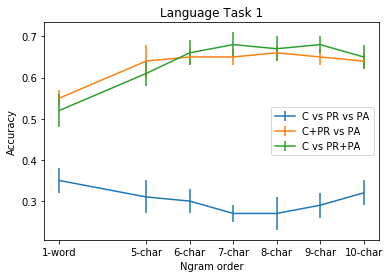

Taaloefening 2


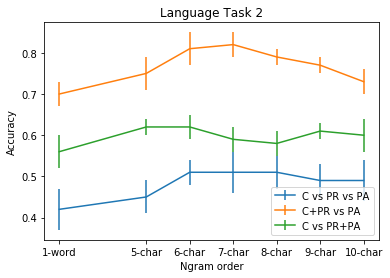

Taaloefening 1+2


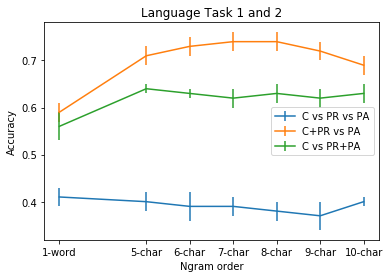

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
print("Taaloefening 1")
# example data
y_c_vs_pr_vs_pa = [.35,.31, .30,.27,.27,.29,.32]
yerr_c_vs_pr_vs_pa = [.03,.04,.03,.02,.04,.03,.03]
x_values = ["1-word", "5-char", "6-char", "7-char", "8-char", "9-char", "10-char"]

y_cpr_vs_pa =  [.55,.64,.65,.65,.66,.65,.64]
yerr_cpr_vs_pa = [.02,.04,.02,.02,.02,.02,.02]

y_c_vs_prpa = [.52,.61,.66,.68,.67,.68,.65]
yerr_c_vs_prpa = [.04,.03,.03,.03,.03,.02,.03]

x = [3,5,6,7,8,9,10]

fig, ax = plt.subplots()
ax.set_xlabel("Ngram order")
ax.set_ylabel('Accuracy')
ax.errorbar(x, y_c_vs_pr_vs_pa, yerr=yerr_c_vs_pr_vs_pa, label = "C vs PR vs PA")
ax.errorbar(x, y_cpr_vs_pa, yerr=yerr_cpr_vs_pa, label = "C+PR vs PA")
ax.errorbar(x, y_c_vs_prpa, yerr=yerr_c_vs_prpa, label = "C vs PR+PA")
plt.xticks(x, x_values)
plt.legend()
plt.title("Language Task 1")
plt.savefig("ngram_tracing_taaloefening1")
plt.show()
print("Taaloefening 2")

y_c_vs_pr_vs_pa = [.42,.45, .51,.51,.51,.49,.49]
yerr_c_vs_pr_vs_pa = [.05,.04,.03,.05,.04,.04,.05]

y_cpr_vs_pa =  [.70,.75,.81,.82,.79,.77,.73]
yerr_cpr_vs_pa = [.03,.04,.04,.03,.02,.02,.03]

y_c_vs_prpa = [.56,.62,.62,.59,.58,.61,.60]
yerr_c_vs_prpa = [.04,.02,.03,.03,.03,.02,.04]

fig, ax = plt.subplots()
ax.set_xlabel("Ngram order")
ax.set_ylabel('Accuracy')
ax.errorbar(x, y_c_vs_pr_vs_pa, yerr=yerr_c_vs_pr_vs_pa, label = "C vs PR vs PA")
ax.errorbar(x, y_cpr_vs_pa, yerr=yerr_cpr_vs_pa, label = "C+PR vs PA")
ax.errorbar(x, y_c_vs_prpa, yerr=yerr_c_vs_prpa, label = "C vs PR+PA")
plt.title("Language Task 2")
plt.xticks(x, x_values)
plt.legend()
plt.savefig("ngram_tracing_taaloefening2")
plt.show()
print("Taaloefening 1+2")

y_c_vs_pr_vs_pa = [.41,.40, .39,.39,.38,.37,.40]
yerr_c_vs_pr_vs_pa = [.02,.02,.03,.02,.02,.03,.01]

y_cpr_vs_pa =  [.59,.71,.73,.74,.74,.72,.69]
yerr_cpr_vs_pa = [.02,.02,.02,.02,.02,.02,.02]

y_c_vs_prpa = [.56,.64,.63,.62,.63,.62,.63]
yerr_c_vs_prpa = [.03,.01,.01,.02,.02,.02,.02]

fig, ax = plt.subplots()
ax.set_xlabel("Ngram order")
ax.set_ylabel('Accuracy')
ax.errorbar(x, y_c_vs_pr_vs_pa, yerr=yerr_c_vs_pr_vs_pa, label = "C vs PR vs PA")
ax.errorbar(x, y_cpr_vs_pa, yerr=yerr_cpr_vs_pa, label = "C+PR vs PA")
ax.errorbar(x, y_c_vs_prpa, yerr=yerr_c_vs_prpa, label = "C vs PR+PA")
plt.xticks(x, x_values)
plt.legend()
plt.title("Language Task 1 and 2")
plt.savefig("ngram_tracing_taaloefening12")
plt.show()


In [ ]:
df_ngrams = df_ngrams.loc[~df_ngrams.index.duplicated(keep='first')]

In [ ]:
steps = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
controls = []
controls_correct = 0
acute = []
acute_correct = 0
remission = []
remission_correct = 0
for participant,row in df_ngrams.iterrows():
    if df_ngrams.loc[participant, "Label"] == 0:
        controls.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))
        if df_ngrams.loc[participant, "Predicted Label"] == 0:
            controls_correct += 1
    if df_ngrams.loc[participant, "Label"] == 1:
        acute.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))
        if df_ngrams.loc[participant, "Predicted Label"] == 1:
            acute_correct += 1
    if df_ngrams.loc[participant, "Label"] == 2:
        remission.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))
        if df_ngrams.loc[participant, "Predicted Label"] == 2:
            remission_correct += 1

y = []
y1 = []
y2 = []

for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in controls:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y.append(accuracy)
    if len(lsttotal) == 0:
        y.append(0)
for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in acute:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y1.append(accuracy)
    if len(lsttotal) == 0:
        y1.append(0)
y2 = []
for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in remission:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y2.append(accuracy)
    if len(lsttotal) == 0:
        y2.append(0)
print("Control vs Acute vs Remission")
plt.plot(steps,y, label = "Control")
plt.plot(steps,y1, label = "Acute")
plt.plot(steps,y2, label = "Remission")
plt.xlabel("Overlap Coefficient Difference between 1st and 2nd highest Coefficent")
plt.ylabel("Accuracy")
plt.title("")
plt.legend()
plt.show()

In [ ]:
steps = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
controls = []
patients = []
for participant,row in df_ngrams.iterrows():
    if df_ngrams.loc[participant, "Label"] == 0:
        controls.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))

    if df_ngrams.loc[participant, "Label"] == 1:
        patients.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))

    if df_ngrams.loc[participant, "Label"] == 2:
        patients.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))

y = []
y1 = []

for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in controls:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y.append(accuracy)
    if len(lsttotal) == 0:
        y.append(0)
for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in patients:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
            elif df_ngrams.loc[tupl[1], "Predicted Label"] == 1:
                lstcorre.append(tupl)
            elif df_ngrams.loc[tupl[1], "Predicted Label"] == 2:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y1.append(accuracy)
    if len(lsttotal) == 0:
        y1.append(0)
print("Control vs Patients (Acute and Remission)")
plt.plot(steps,y, label = "Control")
plt.plot(steps,y1, label = "Patients (Acute and Remission)")
plt.xlabel("Overlap Coefficient Difference between 1st and 2nd highest Coefficent")
plt.ylabel("Accuracy")
plt.title("")
plt.legend()
plt.show()

In [ ]:
steps = [0.0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2]
controls_remission = []
acute = []
for participant,row in df_ngrams.iterrows():
    if df_ngrams.loc[participant, "Label"] == 0:
        controls_remission.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))

    if df_ngrams.loc[participant, "Label"] == 1:
        acute.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))

    if df_ngrams.loc[participant, "Label"] == 2:
        controls_remission.append((round(df_ngrams.loc[participant, "Overlap Difference"],2),participant))

y = []
y1 = []

for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in controls_remission:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
            elif df_ngrams.loc[tupl[1], "Predicted Label"] == 0:
                lstcorre.append(tupl)
            elif df_ngrams.loc[tupl[1], "Predicted Label"] == 2:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y.append(accuracy)
    if len(lsttotal) == 0:
        y.append(0)
for number in steps:
    lsttotal = []
    lstcorre = []
    graph = []
    for tupl in acute:
        if tupl[0] == number:
            lsttotal.append(tupl)
            if df_ngrams.loc[tupl[1], "Predicted Label"] == df_ngrams.loc[tupl[1], "Label"]:
                lstcorre.append(tupl)
    if len(lsttotal) != 0:
        accuracy = len(lstcorre) / len(lsttotal)
        y1.append(accuracy)
    if len(lsttotal) == 0:
        y1.append(0)
print("Control and Remission vs Acute")
plt.plot(steps,y, label = "Control and Remission")
plt.plot(steps,y1, label = "Acute")
plt.xlabel("Overlap Coefficient Difference between 1st and 2nd highest Coefficent")
plt.ylabel("Accuracy")
plt.title("")
plt.legend()
plt.show()

In [92]:
def forming_graph(participant_ngrams, participant_group):
    counting_ngrams = []
    percentage_axis = []
    seen_ngrams = []
    for tupl in participant_group:
        seen_ngrams.append(tupl)
        coefficient = overlapp_coefficient(participant_ngrams, seen_ngrams)
        percentage_axis.append(coefficient)
    graph = pd.Series(percentage_axis)
    return graph

def plot_graph(participant_id, graph, graph1, **kwargs):
    graph2 = kwargs.get("graph2", None)
    plt.plot(graph, label = "(C) Controls")
    plt.plot(graph1, label = "(PA) Acute Patients")
    plt.plot(graph2, label = "(PR) Patients in Remission")
    plt.title(participant_id)
    plt.xlabel('Ngrams seen')
    plt.ylabel('Overlap Coefficient')
    plt.legend()
    plt.savefig("P352_overlap_plot")
    plt.show()

In [90]:
df_ngrams = create_dataframe("both","chars", 8, "three_groups", participant_grouping = None)
df_ngrams = df_ngrams.set_index("Participant")

### Increase of overlap coefficient by incremental increase of "seen" ngrams for 8-char-ngrams

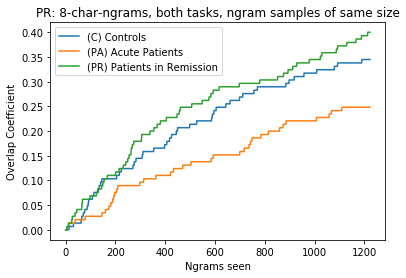

In [91]:
graph0 = forming_graph(df_ngrams.loc["P352","Participant Ngrams"], df_ngrams.loc["P352","Random 0"])
graph1 = forming_graph(df_ngrams.loc["P352","Participant Ngrams"], df_ngrams.loc["P352","Random 1"])
graph2 = forming_graph(df_ngrams.loc["P352","Participant Ngrams"], df_ngrams.loc["P352","Random 2"])
plot_graph("PR: 8-char-ngrams, both tasks, ngram samples of same size", graph0, graph1, graph2 = graph2)

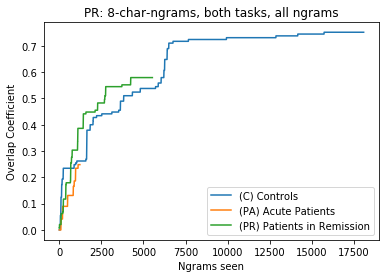

In [94]:
graph0 = forming_graph(df_ngrams.loc["P352","Participant Ngrams"], df_ngrams.loc["P352","Ngrams 0"])
graph1 = forming_graph(df_ngrams.loc["P352","Participant Ngrams"], df_ngrams.loc["P352","Ngrams 1"])
graph2 = forming_graph(df_ngrams.loc["P352","Participant Ngrams"], df_ngrams.loc["P352","Ngrams 2"])
plot_graph("PR: 8-char-ngrams, both tasks, all ngrams", graph0, graph1, graph2 = graph2)

In [ ]:
# graphs for the data from both tasks, character ngrams, ngram order 3 and three participant groups. 
# the graphs indicate how the overlap coefficient per participant changes while its getting fed the words/ngrams from the three test groups

for participant, row in df_ngrams.iterrows():
    participant_id = row[0]
    participant_ngrams = df_ngrams.iloc[participant]["Participant Ngrams"]

    graph0 = forming_graph(participant_ngrams, df_ngrams.iloc[participant]["Ngrams 0"])
    graph1 = forming_graph(participant_ngrams, df_ngrams.iloc[participant]["Ngrams 1"])
    graph2 = forming_graph(participant_ngrams, df_ngrams.iloc[participant]["Ngrams 2"])
    plot_graph(participant_id, graph0, graph1, graph2 = graph2)

# Naive Bayes and Support Vector Machine

## Controls (0) versus Acute (1) versus Remission (2)

In [10]:
df.head()

,Label,Taaloefening 1,Taaloefening 2,Text
ID,,,,
P642,2,NaN,Terwijl de kok zijn deeg aan het voorbereiden ...,Terwijl de kok zijn deeg aan het voorbereiden ...
C021,0,"Je neemt de nodige hoeveelheid water, deze gie...",NaN,"Je neemt de nodige hoeveelheid water, deze gie..."
C022,0,NaN,De kok is een pizza aan het maken in zijn rest...,De kok is een pizza aan het maken in zijn rest...
C041,0,NaN,Op de printjes zie je een pizza maker die een ...,Op de printjes zie je een pizza maker die een ...
C042,0,"Je neemt een hoog bokaal, een filter. De filte...",NaN,"Je neemt een hoog bokaal, een filter. De filte..."


In [50]:
print("Taaloefening 1:", "\n")
corpus = []
lemmas = []
y = []
for participant, row in df.iterrows():
    if isinstance(df.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])
        lemmas.append(row[4])
        y.append(row[0])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1: 

---------- Naive Bayes ----------
Confusion Matrix: 
 [[7 1 0]
 [7 1 0]
 [1 0 0]]
              precision    recall  f1-score   support

           0       0.47      0.88      0.61         8
           1       0.50      0.12      0.20         8
           2       0.00      0.00      0.00         1

    accuracy                           0.47        17
   macro avg       0.32      0.33      0.27        17
weighted avg       0.45      0.47      0.38        17

Accuracy: 0.66 (+/- 0.15)
K-Fold Cross Validation: Accuracy: 63.333% (+/- 35.355%)
Leave-One-Out Cross Validation: Accuracy: 61.905% (+/- 48.562%)
Repeated Random Test-Train Splits: Accuracy: 61.071% (+/- 11.232%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[7 1 0]
 [0 7 1]
 [0 1 0]]


/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.78      0.88      0.82         8
           2       0.00      0.00      0.00         1

    accuracy                           0.82        17
   macro avg       0.59      0.58      0.59        17
weighted avg       0.84      0.82      0.83        17

Accuracy: 0.67 (+/- 0.16)
K-Fold Cross Validation: Accuracy: 67.667% (+/- 24.757%)
Leave-One-Out Cross Validation: Accuracy: 65.476% (+/- 47.545%)
Repeated Random Test-Train Splits: Accuracy: 67.143% (+/- 6.349%)
with lemmas:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[11  1  0]
 [ 3  1  0]
 [ 0  1  0]]
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        12
           1       0.33      0.25      0.29         4
           2       0.00      0.00      0.00         1

    accuracy                           0.71        17
   macro avg       0.37      0

/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defin

Repeated Random Test-Train Splits: Accuracy: 58.929% (+/- 8.338%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[9 3 0]
 [2 2 0]
 [1 0 0]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75        12
           1       0.40      0.50      0.44         4
           2       0.00      0.00      0.00         1

    accuracy                           0.65        17
   macro avg       0.38      0.42      0.40        17
weighted avg       0.62      0.65      0.63        17

Accuracy: 0.67 (+/- 0.22)
K-Fold Cross Validation: Accuracy: 75.667% (+/- 23.912%)
Leave-One-Out Cross Validation: Accuracy: 73.810% (+/- 43.967%)
Repeated Random Test-Train Splits: Accuracy: 71.071% (+/- 6.071%)
with BOTH:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[21  0  0]
 [ 3  9  0]
 [ 0  1  0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        21
           1       0.90      0.75 

/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Leave-One-Out Cross Validation: Accuracy: 86.905% (+/- 33.735%)
Repeated Random Test-Train Splits: Accuracy: 76.607% (+/- 4.549%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[21  0  0]
 [ 0 12  0]
 [ 0  0  1]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         1

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34

Accuracy: 0.98 (+/- 0.03)
K-Fold Cross Validation: Accuracy: 98.857% (+/- 3.876%)
Leave-One-Out Cross Validation: Accuracy: 98.810% (+/- 10.846%)
Repeated Random Test-Train Splits: Accuracy: 87.321% (+/- 6.209%)


In [51]:
print("Taaloefening 2:", "\n")
corpus = []
lemmas = []
y = []
for participant, row in df.iterrows():
    if isinstance(df.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        lemmas.append(row[4])
        y.append(row[0])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 2: 

---------- Naive Bayes ----------
Confusion Matrix: 
 [[7 0 2]
 [1 0 1]
 [5 0 0]]
              precision    recall  f1-score   support

           0       0.54      0.78      0.64         9
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         5

    accuracy                           0.44        16
   macro avg       0.18      0.26      0.21        16
weighted avg       0.30      0.44      0.36        16

Accuracy: 0.52 (+/- 0.11)
K-Fold Cross Validation: Accuracy: 52.667% (+/- 34.296%)
Leave-One-Out Cross Validation: Accuracy: 53.165% (+/- 49.900%)
Repeated Random Test-Train Splits: Accuracy: 54.815% (+/- 9.192%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[6 0 3]
 [1 0 1]
 [1 0 4]]
              precision    recall  f1-score   support

           0       0.75      0.67      0.71         9
           1       0.00      0.00      0.00         2
           2       0.50      0.80      0.62     

/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K-Fold Cross Validation: Accuracy: 61.333% (+/- 22.838%)
Leave-One-Out Cross Validation: Accuracy: 63.291% (+/- 48.201%)
Repeated Random Test-Train Splits: Accuracy: 62.963% (+/- 5.238%)
with lemmas:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[7 0 0]
 [0 1 0]
 [7 0 1]]
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         7
           1       1.00      1.00      1.00         1
           2       1.00      0.12      0.22         8

    accuracy                           0.56        16
   macro avg       0.83      0.71      0.63        16
weighted avg       0.78      0.56      0.47        16

Accuracy: 0.56 (+/- 0.20)
K-Fold Cross Validation: Accuracy: 57.667% (+/- 33.905%)
Leave-One-Out Cross Validation: Accuracy: 60.759% (+/- 48.829%)
Repeated Random Test-Train Splits: Accuracy: 55.556% (+/- 9.072%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[4 0 3]
 [0 0 1]
 [3 0 5]]
              precision    re

/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K-Fold Cross Validation: Accuracy: 55.333% (+/- 26.654%)
Leave-One-Out Cross Validation: Accuracy: 58.228% (+/- 49.318%)
Repeated Random Test-Train Splits: Accuracy: 59.630% (+/- 6.718%)

 with BOTH:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[18  0  1]
 [ 0  0  1]
 [ 8  0  4]]
              precision    recall  f1-score   support

           0       0.69      0.95      0.80        19
           1       0.00      0.00      0.00         1
           2       0.67      0.33      0.44        12

    accuracy                           0.69        32
   macro avg       0.45      0.43      0.41        32
weighted avg       0.66      0.69      0.64        32

Accuracy: 0.82 (+/- 0.08)
K-Fold Cross Validation: Accuracy: 80.095% (+/- 21.048%)


/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Leave-One-Out Cross Validation: Accuracy: 81.646% (+/- 38.711%)
Repeated Random Test-Train Splits: Accuracy: 66.604% (+/- 4.548%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[19  0  0]
 [ 0  1  0]
 [ 0  0 12]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00        12

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

Accuracy: 0.99 (+/- 0.02)
K-Fold Cross Validation: Accuracy: 98.857% (+/- 3.876%)
Leave-One-Out Cross Validation: Accuracy: 98.734% (+/- 11.179%)
Repeated Random Test-Train Splits: Accuracy: 83.208% (+/- 2.728%)


In [52]:
print("Taaloefening 1 & 2:", "\n")
corpus = []
lemmas = []
y = []
for participant, row in df.iterrows():
    lemmas.append(df.loc[participant, "Lemmas"])
    if isinstance(df.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])
        y.append(row[0])
    if isinstance(df.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        y.append(row[0])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
vectorizer = CountVectorizer()
print("\n", "with lemmas:")
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, df["Label"], test_size = 0.20)
model, y_pred, scores = naivebayes(X,df["Label"],X_train, y_train)
classifierresults(X, df["Label"], y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,df["Label"],X_train, y_train)
classifierresults(X, df["Label"], y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1 & 2: 

---------- Naive Bayes ----------
Confusion Matrix: 
 [[16  3  0]
 [ 1  7  0]
 [ 4  0  2]]
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        19
           1       0.70      0.88      0.78         8
           2       1.00      0.33      0.50         6

    accuracy                           0.76        33
   macro avg       0.82      0.68      0.69        33
weighted avg       0.79      0.76      0.74        33

Accuracy: 0.58 (+/- 0.10)
K-Fold Cross Validation: Accuracy: 51.238% (+/- 26.368%)
Leave-One-Out Cross Validation: Accuracy: 55.828% (+/- 49.659%)
Repeated Random Test-Train Splits: Accuracy: 57.222% (+/- 6.332%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[16  2  1]
 [ 1  6  1]
 [ 2  0  4]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.75      0.75      0.75         8
           2       0.67   

## Controls (0) versus Patients (1, Acute and Remission)

In [57]:
df_controlpatients = df.copy()
for participant,row in df_controlpatients.iterrows():
    if row[0] == 2:
        df_controlpatients.loc[participant, "Label"] = 1


In [58]:
# Control vs Patients
print("Taaloefening 1:", "\n")
corpus = []
lemmas = []
y = []
for participant, row in df_controlpatients.iterrows():
    if isinstance(df_controlpatients.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])
        lemmas.append(df.loc[participant, "Lemmas"])
        y.append(row[0])
        
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1: 

---------- Naive Bayes ----------
Confusion Matrix: 
 [[ 6  0]
 [11  0]]
              precision    recall  f1-score   support

           0       0.35      1.00      0.52         6
           1       0.00      0.00      0.00        11

    accuracy                           0.35        17
   macro avg       0.18      0.50      0.26        17
weighted avg       0.12      0.35      0.18        17

Accuracy: 0.68 (+/- 0.13)
K-Fold Cross Validation: Accuracy: 69.667% (+/- 31.700%)
Leave-One-Out Cross Validation: Accuracy: 69.048% (+/- 46.230%)
Repeated Random Test-Train Splits: Accuracy: 62.500% (+/- 10.504%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[5 1]
 [7 4]]
              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.80      0.36      0.50        11

    accuracy                           0.53        17
   macro avg       0.61      0.60      0.53        17
weighted avg  

/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K-Fold Cross Validation: Accuracy: 67.667% (+/- 24.757%)
Leave-One-Out Cross Validation: Accuracy: 69.048% (+/- 46.230%)
Repeated Random Test-Train Splits: Accuracy: 69.643% (+/- 6.029%)
with lemmas:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[11  3]
 [ 2  1]]
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.25      0.33      0.29         3

    accuracy                           0.71        17
   macro avg       0.55      0.56      0.55        17
weighted avg       0.74      0.71      0.72        17

Accuracy: 0.62 (+/- 0.11)
K-Fold Cross Validation: Accuracy: 58.333% (+/- 33.250%)
Leave-One-Out Cross Validation: Accuracy: 59.524% (+/- 49.085%)
Repeated Random Test-Train Splits: Accuracy: 62.857% (+/- 9.340%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[10  4]
 [ 1  2]]
              precision    recall  f1-score   support

           0       0.91      0.71      0.80   

In [61]:
df_controlpatients.head()

,Label,Taaloefening 1,Taaloefening 2,Text,Lemmas
ID,,,,,
P642,1,NaN,Terwijl de kok zijn deeg aan het voorbereiden ...,Terwijl de kok zijn deeg aan het voorbereiden ...,terwijl de kok zijn deeg aan_het voorbereiden ...
C021,0,"Je neemt de nodige hoeveelheid water, deze gie...",NaN,"Je neemt de nodige hoeveelheid water, deze gie...","je nemen de nodig hoeveelheid water , deze gie..."
C022,0,NaN,De kok is een pizza aan het maken in zijn rest...,De kok is een pizza aan het maken in zijn rest...,de kok zijn een pizza aan_het maken in zijn re...
C041,0,NaN,Op de printjes zie je een pizza maker die een ...,Op de printjes zie je een pizza maker die een ...,op de prin zien je een pizza maker die een dee...
C042,0,"Je neemt een hoog bokaal, een filter. De filte...",NaN,"Je neemt een hoog bokaal, een filter. De filte...","je nemen een hoog bokaal , een filter . de fil..."


In [70]:
# Control vs Patients
print("Taaloefening 1:", "\n")
corpus = []
lemmas = []
y = []
for participant, row in df_controlpatients.iterrows():
    if isinstance(df_controlpatients.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])
        lemmas.append(df.loc[participant, "Lemmas"])
        y.append(row[0])
        
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1: 

---------- Naive Bayes ----------
Confusion Matrix: 
 [[9 4]
 [2 2]]
              precision    recall  f1-score   support

           0       0.82      0.69      0.75        13
           1       0.33      0.50      0.40         4

    accuracy                           0.65        17
   macro avg       0.58      0.60      0.58        17
weighted avg       0.70      0.65      0.67        17

Accuracy: 0.68 (+/- 0.13)
K-Fold Cross Validation: Accuracy: 69.667% (+/- 31.700%)
Leave-One-Out Cross Validation: Accuracy: 69.048% (+/- 46.230%)
Repeated Random Test-Train Splits: Accuracy: 62.500% (+/- 10.504%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[8 5]
 [1 3]]
              precision    recall  f1-score   support

           0       0.89      0.62      0.73        13
           1       0.38      0.75      0.50         4

    accuracy                           0.65        17
   macro avg       0.63      0.68      0.61        17
weighted avg      

In [62]:
# Control vs Patients
print("Taaloefening 2:", "\n")
corpus = []
lemmas = []
y = []
for participant, row in df_controlpatients.iterrows():
    if isinstance(df_controlpatients.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        lemmas.append(df.loc[participant, "Lemmas"])
        y.append(row[0])
        
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 2: 

---------- Naive Bayes ----------
Confusion Matrix: 
 [[6 1]
 [6 3]]
              precision    recall  f1-score   support

           0       0.50      0.86      0.63         7
           1       0.75      0.33      0.46         9

    accuracy                           0.56        16
   macro avg       0.62      0.60      0.55        16
weighted avg       0.64      0.56      0.54        16

Accuracy: 0.56 (+/- 0.07)
K-Fold Cross Validation: Accuracy: 56.667% (+/- 31.002%)
Leave-One-Out Cross Validation: Accuracy: 62.025% (+/- 48.532%)
Repeated Random Test-Train Splits: Accuracy: 58.148% (+/- 10.612%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[5 2]
 [3 6]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.75      0.67      0.71         9

    accuracy                           0.69        16
   macro avg       0.69      0.69      0.69        16
weighted avg      

In [71]:
print("Taaloefening 1 & 2:")
corpus = []
lemmas = []
y = []
for participant, row in df_controlpatients.iterrows():
    lemmas.append(df_controlpatients.loc[participant, "Lemmas"])
    if isinstance(df_controlpatients.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])         
        y.append(row[0])
    if isinstance(df_controlpatients.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        y.append(row[0])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X, y, X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X, y, X_train, y_train)
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1 & 2:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[12  2]
 [18  1]]
              precision    recall  f1-score   support

           0       0.40      0.86      0.55        14
           1       0.33      0.05      0.09        19

    accuracy                           0.39        33
   macro avg       0.37      0.45      0.32        33
weighted avg       0.36      0.39      0.28        33

Accuracy: 0.56 (+/- 0.13)
K-Fold Cross Validation: Accuracy: 58.952% (+/- 30.958%)
Leave-One-Out Cross Validation: Accuracy: 60.123% (+/- 48.965%)
Repeated Random Test-Train Splits: Accuracy: 59.815% (+/- 5.620%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[9 9]
 [8 7]]
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.44      0.47      0.45        15

    accuracy                           0.48        33
   macro avg       0.48      0.48      0.48        33
weighted avg 

## Controls (0) and Patients in Remission versus Acute Patients

In [6]:
df_conrem_acute = df.copy()
for participant,row in df_conrem_acute.iterrows():
    if row[0] == 2:
        df_conrem_acute.loc[participant, "Label"] = 0

In [7]:
print("Taaloefening 1:")
corpus = []
lemmas = []
y = []
for participant, row in df_conrem_acute.iterrows():
    if isinstance(df_conrem_acute.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])         
        y.append(row[0])
        lemmas.append(df.loc[participant, "Lemmas"])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X, y, X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X, y, X_train, y_train)
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[9 0]
 [8 0]]
              precision    recall  f1-score   support

           0       0.53      1.00      0.69         9
           1       0.00      0.00      0.00         8

    accuracy                           0.53        17
   macro avg       0.26      0.50      0.35        17
weighted avg       0.28      0.53      0.37        17

Accuracy: 0.69 (+/- 0.13)
K-Fold Cross Validation: Accuracy: 66.667% (+/- 31.798%)
Leave-One-Out Cross Validation: Accuracy: 63.095% (+/- 48.255%)
Repeated Random Test-Train Splits: Accuracy: 65.357% (+/- 8.755%)


/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[9 3]
 [2 3]]
              precision    recall  f1-score   support

           0       0.82      0.75      0.78        12
           1       0.50      0.60      0.55         5

    accuracy                           0.71        17
   macro avg       0.66      0.68      0.66        17
weighted avg       0.72      0.71      0.71        17

Accuracy: 0.75 (+/- 0.16)
K-Fold Cross Validation: Accuracy: 72.000% (+/- 22.716%)
Leave-One-Out Cross Validation: Accuracy: 70.238% (+/- 45.721%)
Repeated Random Test-Train Splits: Accuracy: 72.857% (+/- 5.803%)
with lemmas:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[9 1]
 [6 1]]
              precision    recall  f1-score   support

           0       0.60      0.90      0.72        10
           1       0.50      0.14      0.22         7

    accuracy                           0.59        17
   macro avg       0.55      0.52      0.47        17
weighted avg       0.56 

In [8]:
print("Taaloefening2:")
corpus = []
lemmas = []
y = []
for participant, row in df_conrem_acute.iterrows():
    if isinstance(df_conrem_acute.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        y.append(row[0])
        lemmas.append(df.loc[participant, "Lemmas"])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X, y, X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X, y, X_train, y_train)
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening2:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[14  0]
 [ 1  1]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.50      0.67         2

    accuracy                           0.94        16
   macro avg       0.97      0.75      0.82        16
weighted avg       0.94      0.94      0.93        16

Accuracy: 0.95 (+/- 0.05)
K-Fold Cross Validation: Accuracy: 93.667% (+/- 15.861%)
Leave-One-Out Cross Validation: Accuracy: 93.671% (+/- 24.349%)
Repeated Random Test-Train Splits: Accuracy: 94.444% (+/- 3.795%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[13  0]
 [ 3  0]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        13
           1       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.41      0.50      0.45        16
weighted avg  

/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


K-Fold Cross Validation: Accuracy: 92.333% (+/- 16.653%)
Leave-One-Out Cross Validation: Accuracy: 93.671% (+/- 24.349%)
Repeated Random Test-Train Splits: Accuracy: 92.963% (+/- 3.867%)
with lemmas:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[15  0]
 [ 1  0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       0.00      0.00      0.00         1

    accuracy                           0.94        16
   macro avg       0.47      0.50      0.48        16
weighted avg       0.88      0.94      0.91        16

Accuracy: 0.95 (+/- 0.05)
K-Fold Cross Validation: Accuracy: 95.000% (+/- 14.907%)
Leave-One-Out Cross Validation: Accuracy: 93.671% (+/- 24.349%)
Repeated Random Test-Train Splits: Accuracy: 94.444% (+/- 3.795%)


/Users/lisabecker/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[14  1]
 [ 1  0]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.00      0.00      0.00         1

    accuracy                           0.88        16
   macro avg       0.47      0.47      0.47        16
weighted avg       0.88      0.88      0.88        16

Accuracy: 0.92 (+/- 0.05)
K-Fold Cross Validation: Accuracy: 93.667% (+/- 15.861%)
Leave-One-Out Cross Validation: Accuracy: 93.671% (+/- 24.349%)
Repeated Random Test-Train Splits: Accuracy: 92.222% (+/- 3.867%)

 with BOTH:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[27  0]
 [ 4  1]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        27
           1       1.00      0.20      0.33         5

    accuracy                           0.88        32
   macro avg       0.94      0.60      0.63        32
weighted avg    

In [4]:
print("Taaloefening2:")
corpus = []
lemmas = []
y = []
for participant, row in df_conrem_acute.iterrows():
    if isinstance(df_conrem_acute.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        y.append(row[0])
        lemmas.append(df.loc[participant, "Lemmas"])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X, y, X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X, y, X_train, y_train)
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening2:


NameError: name 'df_conrem_acute' is not defined

In [67]:
print("Taaloefening 1 & 2:")
corpus = []
lemmas = []
y = []
for participant, row in df_conrem_acute.iterrows():
    lemmas.append(df.loc[participant, "Lemmas"])
    if isinstance(df_conrem_acute.loc[participant, "Taaloefening 1"], float) is not True:
        corpus.append(row[1])         
        y.append(row[0])
    if isinstance(df_conrem_acute.loc[participant, "Taaloefening 2"], float) is not True:
        corpus.append(row[2])
        y.append(row[0])
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X, y, X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X, y, X_train, y_train)
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
classifierresults(X, y, y_test, y_pred, scores, model)
print("with lemmas:")
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(lemmas)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
print("\n", "with BOTH:")
corpus += lemmas
y += y
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
model, y_pred, scores = naivebayes(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)
model, y_pred, scores = supportvectormachine(X,y,X_train, y_train)
classifierresults(X, y, y_test, y_pred, scores, model)

Taaloefening 1 & 2:
---------- Naive Bayes ----------
Confusion Matrix: 
 [[22  4]
 [ 4  3]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        26
           1       0.43      0.43      0.43         7

    accuracy                           0.76        33
   macro avg       0.64      0.64      0.64        33
weighted avg       0.76      0.76      0.76        33

Accuracy: 0.78 (+/- 0.10)
K-Fold Cross Validation: Accuracy: 77.333% (+/- 15.210%)
Leave-One-Out Cross Validation: Accuracy: 76.687% (+/- 42.282%)
Repeated Random Test-Train Splits: Accuracy: 75.556% (+/- 6.075%)
---------- Support Vector Machine ---------- 

Confusion Matrix: 
 [[23  5]
 [ 5  0]]
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.00      0.00      0.00         5

    accuracy                           0.70        33
   macro avg       0.41      0.41      0.41        33
weighted 

1844


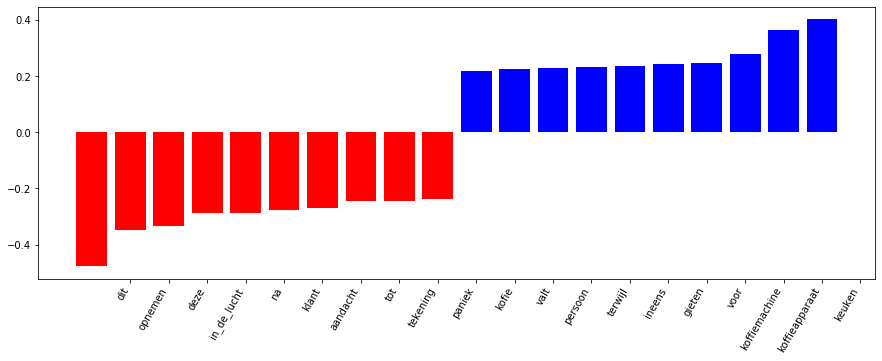

In [72]:
# one of the trials to extract the most important features; the problem was that the classifiers were to different
# to find a way to extract features in a comparable way

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
cv = CountVectorizer()
cv.fit(corpus)
print(len(cv.vocabulary_))
#print(cv.get_feature_names())
X_train = cv.transform(corpus)

svm = LinearSVC()
svm.fit(X_train, y)
plot_coefficients(svm, cv.get_feature_names())